# Informação Georreferenciada

**Alunos:**

- Jamesson Leandro Paiva Santos
- Vinicius Grando Eller

## Como a distribuição espacial de casos de leptospirose no município de São Paulo é influenciada por fatores topográficos e hidrográficos?

O projeto consiste em recriar os experimentos do seguinte estudo ***[INFLUENCE OF TOPOGRAPHIC AND HYDROGRAPHIC FACTORS ON THE SPATIAL
DISTRIBUTION OF LEPTOSPIROSIS DISEASE IN SÃO PAULO COUNTY, BRAZIL: AN APPROACH USING GEOSPATIAL TECHNIQUES AND GIS ANALYSIS](https://isprs-archives.copernicus.org/articles/XLI-B8/197/2016/isprs-archives-XLI-B8-197-2016.pdf)***.


Neste estudo é concluído, por meio do uso de ferramentas de análise geoespacial, que os casos de leptospirose podem estar mais relacionados
aos setores de são paulo localizados em áreas de maior densidade fluvial e aos domicílios situados a distâncias mais curtas dos rios. Por outro lado,
não foi possível afirmar que o relevo do declive contribui significativamente para a localização da leptospirose casos.


### Obtenção dos dados

Para obter os dados necessários, buscamos seguir a metodologia do artigo de referência. No entanto, muitos dos dados originais estavam indisponíveis ou desatualizados nos locais indicados. Assim, as fontes foram adaptadas e os dados coletados da seguinte forma:

#### Casos de Leptospirose

Para a análise de casos de leptospirose, utilizamos dados obtidos do projeto Centro de Estudos da Metrópole. Aplicamos um filtro para selecionar exclusivamente as ocorrências de leptospirose, utilizando os códigos específicos do CID-10. Foram extraídos todos os dados disponíveis entre 2006 e 2016 para garantir a representatividade temporal do estudo.

#### Mapeamento do Território da Cidade de São Paulo

Os dados territoriais de São Paulo também foram obtidos por meio do Centro de Estudos da Metrópole. Um filtro específico foi aplicado para manter exclusivamente as informações da cidade de São Paulo, permitindo uma análise focada no território urbano.

#### Rede Hidrográfica de São Paulo

Para a rede de rios, acessamos dados do projeto Hezbolago, aplicando um filtro para isolar a rede hidrográfica que compõe a cidade de São Paulo. Esses dados são fundamentais para analisar possíveis correlações com áreas de incidência de leptospirose.

#### Dados de Elevação (ASTER GDEM 3)
  
Os dados de elevação do terreno foram obtidos na plataforma EarthData, no formato .tif. Posteriormente, esses dados foram processados e convertidos para o formato GeoDataframe, com um filtro adicional para restringir os dados ao território da cidade de São Paulo.

Todos os dados foram padronizados no sistema de coordenadas EPSG:31983, garantindo a consistência geoespacial dos diferentes conjuntos.

# Install and Downloads

#### Install

In [1]:
# !pip install geopandas --quiet
# !pip install geopy --quiet
# !pip install pointpats==2.3.0 --quiet
# !pip install fiona --quiet
# !pip install seaborn --quiet
# !pip install patool --quiet
# !pip install rasterio --quiet

#### Get leptospirosis anual data

In [2]:
# !curl --create-dirs -o ./data/raw/2007 "https://centrodametropole.fflch.usp.br/en/file/16342/download?token=FIb9Izbo"
# !curl --create-dirs -o ./data/raw/2008 "https://centrodametropole.fflch.usp.br/en/file/16344/download?token=UyzQDObz"
# !curl --create-dirs -o ./data/raw/2009 "https://centrodametropole.fflch.usp.br/en/file/16346/download?token=4P8CmodG"
# !curl --create-dirs -o ./data/raw/2010 "https://centrodametropole.fflch.usp.br/en/file/16348/download?token=B11kDSSw"
# !curl --create-dirs -o ./data/raw/2011 "https://centrodametropole.fflch.usp.br/en/file/16350/download?token=C2BD3Ofw"
# !curl --create-dirs -o ./data/raw/2012 "https://centrodametropole.fflch.usp.br/en/file/16352/download?token=WyPbHV6c"
# !curl --create-dirs -o ./data/raw/2013 "https://centrodametropole.fflch.usp.br/en/file/16354/download?token=MxWjDMBm"
# !curl --create-dirs -o ./data/raw/2014 "https://centrodametropole.fflch.usp.br/en/file/16356/download?token=NZaVwuqk"
# !curl --create-dirs -o ./data/raw/2015 "https://centrodametropole.fflch.usp.br/en/file/16358/download?token=T3u1T-s9"
# !curl --create-dirs -o ./data/raw/2016 "https://centrodametropole.fflch.usp.br/en/file/16360/download?token=M2krwnvQ"

#### Get São Paulo Geo Data

In [3]:
# !curl --create-dirs -o ./data/raw/district "https://centrodametropole.fflch.usp.br/en/file/16274/download?token=Wt_uDOMJ"
# !curl --create-dirs -o ./data/raw/district_image "https://centrodametropole.fflch.usp.br/en/file/16275/download?token=3SWg4nfy"
# hidro https://hezbolago.carto.com/tables/hidrografia_oficial_22_jun_16/public
# gdem https://search.earthdata.nasa.gov/search/granules?sb%5B0%5D=-48.69141%2C-25.64218%2C-43.69922%2C-20.5795&lat=-23.12841796875&long=-50.853515625&zoom=6

# Imports

In [4]:
import os
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import shape
import patoolib
import rasterio
# from google.colab import files
from pointpats import PointPattern, PoissonPointProcess, hull
from pointpats.centrography import (ellipse, mean_center, std_distance,
                                    weighted_mean_center)
from pointpats.distance_statistics import K, Kenv
from rasterio import warp
from rasterio.features import shapes, geometry_mask
from rasterio.plot import show
from rasterio.warp import Resampling, calculate_default_transform, reproject
from shapely.geometry import Point, box

In [5]:
import warnings

warnings.filterwarnings('ignore')

#### Vars

In [6]:
RAW = "./data/raw"
INTERIM = "./data/interim"
PROCESSED = "./data/processed"

COLUMNS = ["DT_INTER", "DIAG_PRINC", "MORTE", "geometry"]
LEPTOS = ["A27", "A270", "A278", "A279"]  # leptospirosis cases according to ICD-10
CRS = "EPSG:31983"

In [7]:
patoolib.util.PATOOL_PATH_TO_7Z = "/opt/homebrew/bin/7z"

# Process and Save Data

### São Paulo geoData

In [8]:
# patoolib.extract_archive(f"{RAW}/district", outdir=f"{PROCESSED}/sp_geo/")
# patoolib.extract_archive(
#     f"{RAW}/district_image", outdir=f"{PROCESSED}/sp_geo/"
# )

In [9]:
# dem_file = f'{RAW}/gdem/ASTGTMV003_S24W047_dem.tif'

# with rasterio.open(dem_file) as src:
#     transform, width, height = rasterio.warp.calculate_default_transform(
#         src.crs, CRS, src.width, src.height, *src.bounds)
#     kwargs = src.meta.copy()
#     kwargs.update({
#         'crs': CRS,
#         'transform': transform,
#         'width': width,
#         'height': height
#     })
#     with rasterio.open(f'{PROCESSED}/gdem/reprojected_dem.tif', 'w', **kwargs) as dst:
#         for i in range(1, src.count + 1):
#             rasterio.warp.reproject(
#                 source=rasterio.band(src, i),
#                 destination=rasterio.band(dst, i),
#                 src_transform=src.transform,
#                 src_crs=src.crs,
#                 dst_transform=transform,
#                 dst_crs=CRS,
#                 resampling=rasterio.warp.Resampling.nearest)

### Health

In [10]:
# lep_hist_data = gpd.GeoDataFrame()

# def process_year(year):
#     patoolib.extract_archive(
#         f"{RAW}/{str(year)}", outdir=f"{INTERIM}/{str(year)}/"
#     )

#     if os.path.isdir(f'{INTERIM}/{year}/{year}/'):
#         lep_year = gpd.read_file(f"{INTERIM}/{year}/{year}/AIH_{year}_CEM.shp")
#         lep_year = lep_year[COLUMNS][lep_year.DIAG_PRINC.isin(LEPTOS)]
#     else:
#         lep_year = gpd.read_file(f"{INTERIM}/{year}/AIH_{year}_CEM.shp")
#         lep_year = lep_year[COLUMNS][lep_year.DIAG_PRINC.isin(LEPTOS)]
    
#     if lep_year.crs:
#         lep_year = lep_year.to_crs(CRS)
#     else:
#         lep_year = lep_year.set_crs("EPSG:4326").to_crs(CRS)

#     return lep_year


# with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
#     results = list(executor.map(process_year, range(2007, 2017)))

# lep_hist_data = pd.concat(results)
# lep_hist_data = gpd.GeoDataFrame(lep_hist_data, crs=CRS,geometry=lep_hist_data.geometry)
# lep_hist_data.to_file(f"{PROCESSED}/health/lep_hist_data.shp")

### Transformations

In [11]:
mun_sp = gpd.read_file(f"{PROCESSED}/sp_geo/district/DisRM07.shp")
hid_sp = gpd.read_file(f"{PROCESSED}/hidrografia_oficial_22_jun_16/hidrografia_oficial_22_jun_16.shp")
lep_sp = gpd.read_file(f"{PROCESSED}/health/lep_hist_data.shp")

In [12]:
mun_sp = mun_sp.set_crs("EPSG:4326").to_crs(CRS)
hid_sp = hid_sp.to_crs(CRS)

In [13]:
mun_sp = mun_sp[mun_sp.MUN_NOME == "SAO PAULO"]
hid_sp = gpd.overlay(hid_sp, mun_sp, how="intersection")
lep_2007 = lep_sp[lep_sp.DT_INTER.str.contains("2007")]

## Análise de dados (2007)

#### Distância dos rios


Processing interval: 0 100


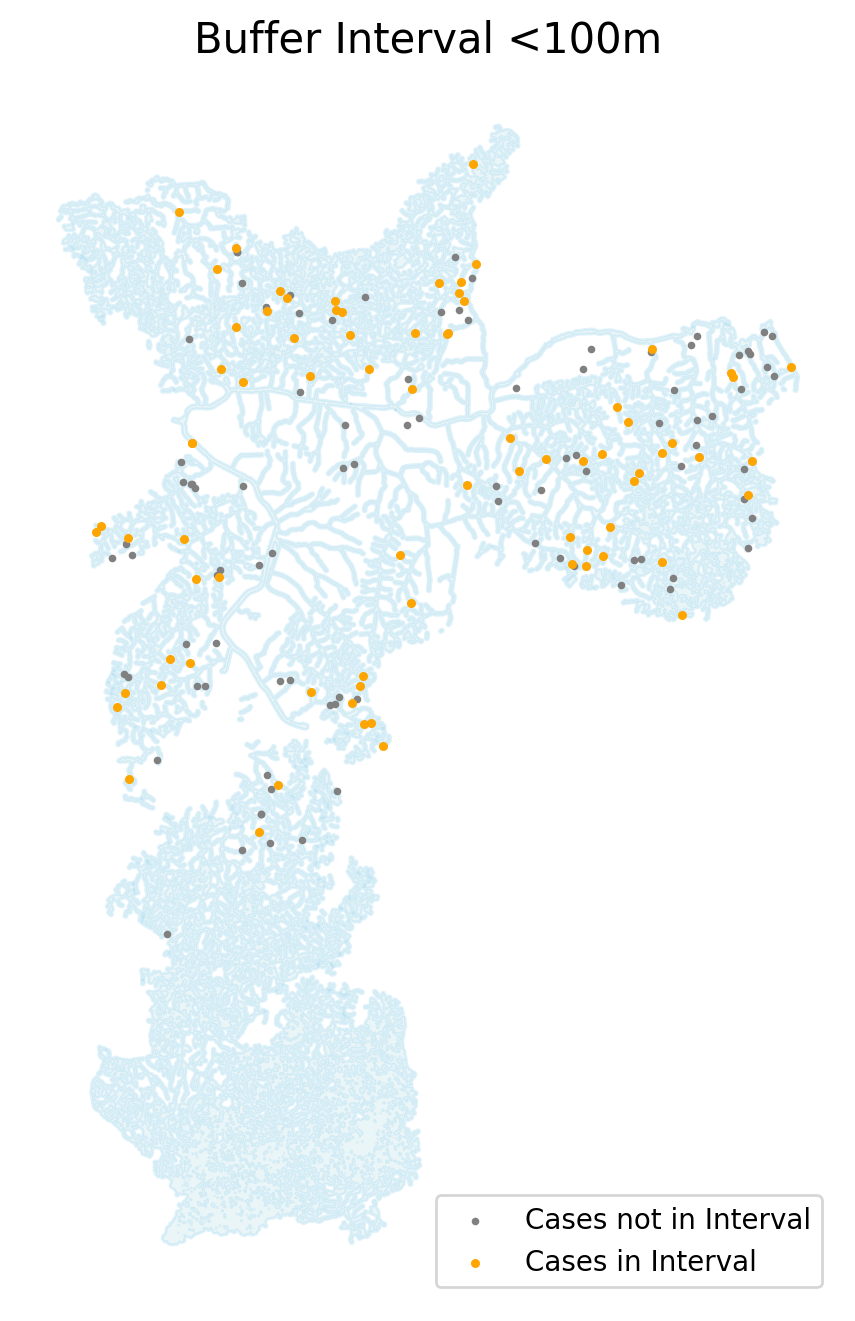

Processing interval: 100 200


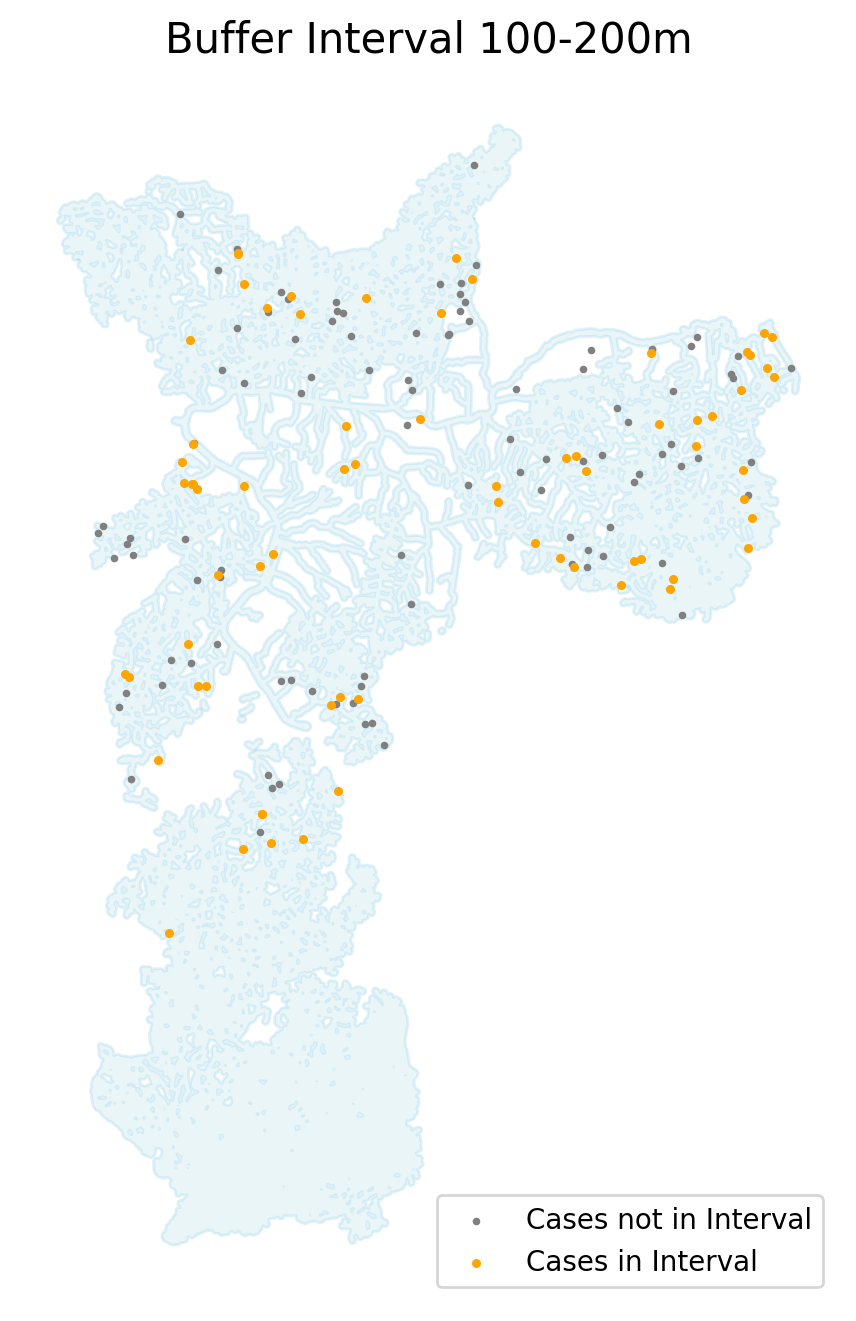

Processing interval: 200 300


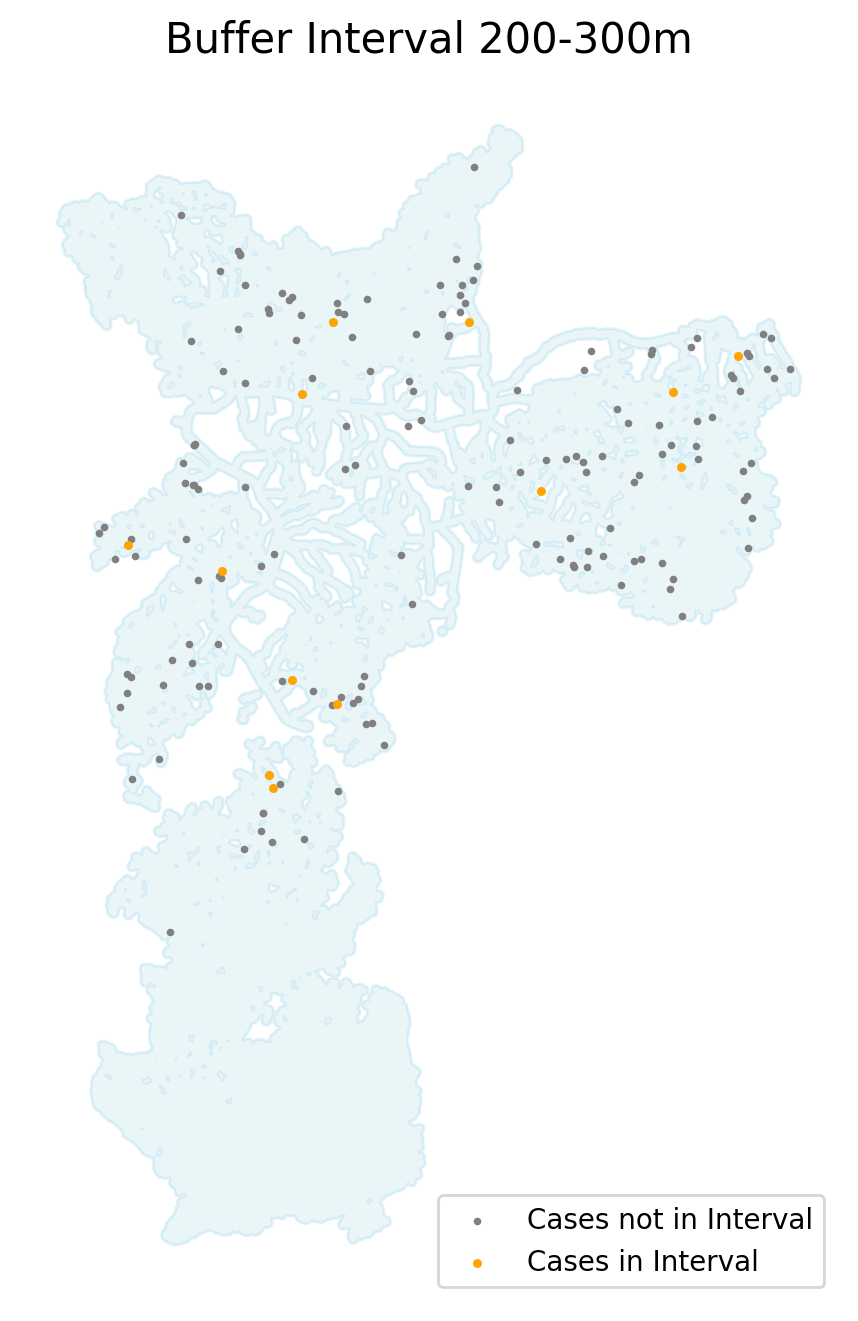

Processing interval: 300 400


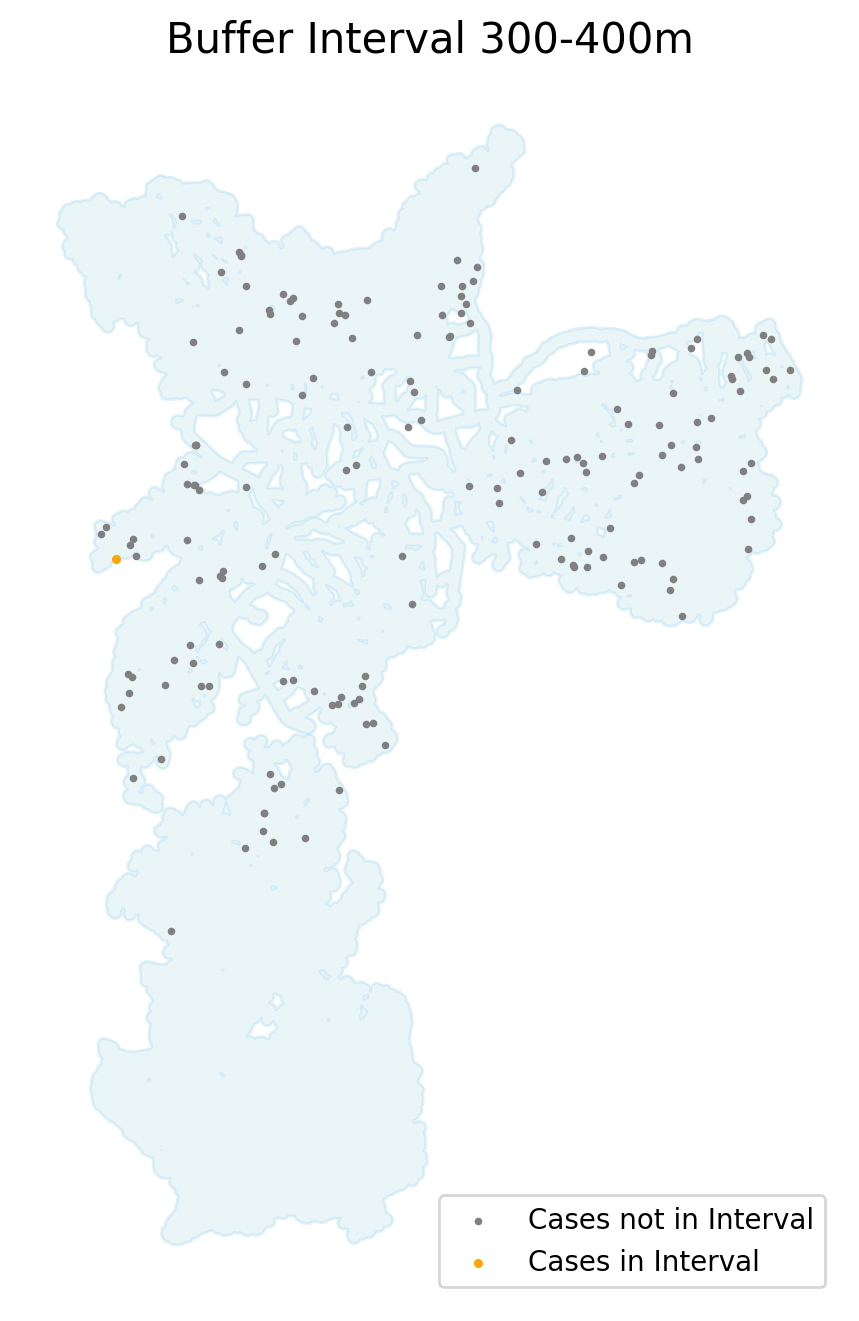

Processing interval: 400 500


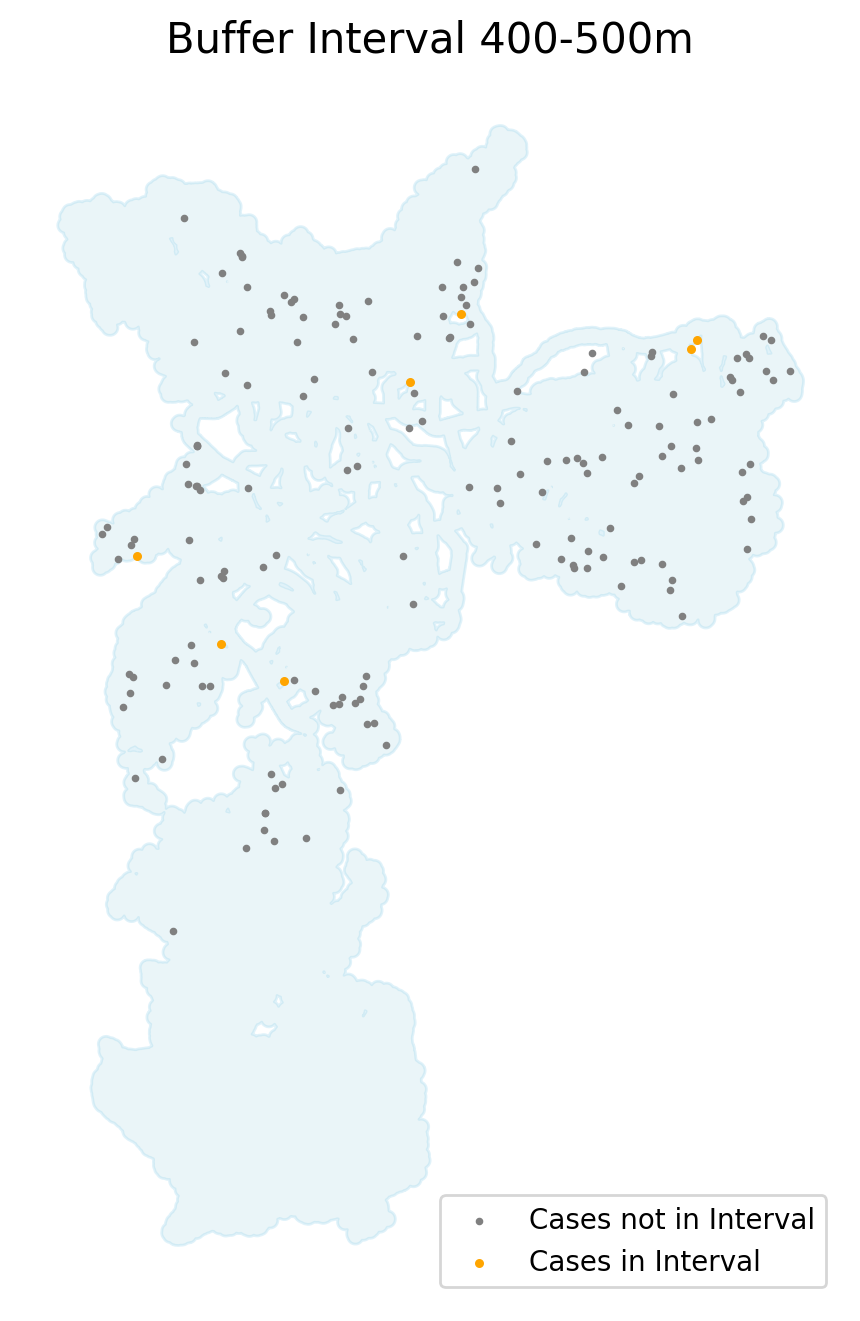

Processing interval: 500 inf
  distance_interval  case_count
0             <100m          78
1          100-200m          70
2          200-300m          13
3          300-400m           1
4          400-500m           7


In [14]:
%config InlineBackend.figure_format='retina'

buffer_intervals = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500), (500, float('inf'))]

def create_buffer_geo_df(distance, hid_sp):
    buffer = hid_sp.buffer(distance).union_all()
    return gpd.GeoDataFrame(geometry=[buffer], crs=hid_sp.crs)

def count_cases_in_interval(lower, upper, lep_2007, hid_sp):
    if upper != float('inf'):
        upper_gdf = create_buffer_geo_df(upper, hid_sp)

        if lower == 0:
            return gpd.sjoin(lep_2007, upper_gdf, predicate='within')
        else:
            lower_gdf = create_buffer_geo_df(lower, hid_sp)
            interval_zone = gpd.overlay(upper_gdf, lower_gdf, how='difference')
            return gpd.sjoin(lep_2007, interval_zone, predicate='within')
    else:
        outer_gdf = create_buffer_geo_df(0.005, hid_sp)
        return lep_2007[~lep_2007.geometry.within(outer_gdf.geometry[0])]

interval_results_list = []

for lower, upper in buffer_intervals:
    print("Processing interval:", lower, upper)  
    cases_in_interval = count_cases_in_interval(lower, upper, lep_2007, hid_sp)

    if upper == float('inf'):
        break
    elif upper == 100:
        interval_name = "<100m"
    else:
        interval_name = f"{lower}-{upper}m"

    interval_results_list.append({'distance_interval': interval_name, 'case_count': len(cases_in_interval)})

    buffer_zone_gdf = create_buffer_geo_df(upper, hid_sp) if upper != float('inf') else create_buffer_geo_df(0.005, hid_sp)

    fig, ax = plt.subplots(figsize=(10,8))

    buffer_zone_gdf.plot(ax=ax, color='lightblue', edgecolor='skyblue', alpha=0.25, label="Buffer Zone")
    lep_2007.plot(ax=ax, color='gray', markersize=3, label="Cases not in Interval")
    cases_in_interval.plot(ax=ax, color='orange', markersize=5, label="Cases in Interval")
    
    ax.set_title(f"Buffer Interval {interval_name}", fontsize=15)
    ax.set_axis_off()
    ax.set_aspect('equal')
    
    plt.legend(loc='lower right')
    plt.show();
    
interval_results = pd.DataFrame(interval_results_list)

print(interval_results)

#### Densisade de rio

In [15]:
if hid_sp.geom_type.iloc[0] != 'LineString':
    hid_sp = hid_sp.explode().reset_index(drop=True)
    hid_sp = hid_sp[hid_sp.geom_type == 'LineString']
    
hid_sp['river_length_km'] = hid_sp.length / 1000

rivden_data = hid_sp.groupby('NOME')['river_length_km'].sum().reset_index()
rivden_data = rivden_data.merge(mun_sp[['NOME', 'geometry']], on='NOME', how='inner')
rivden_data = gpd.GeoDataFrame(rivden_data, crs=CRS,geometry=rivden_data.geometry)
rivden_data['sector_area_km2'] = rivden_data.area / 1e6
rivden_data['RIVDEN'] = rivden_data['river_length_km'] / rivden_data['sector_area_km2']

# # Classify RIVDEN values into specified categories
# rivden_data['RIVDEN_class'] = pd.cut(rivden_data['RIVDEN'],
#                                      bins=[0, 20, 40, 60, 80, 100, float('inf')],
#                                      labels=['0-20 km/km²', '20-40 km/km²', '40-60 km/km²', '60-80 km/km²', '80-100 km/km²', '≥100 km/km²'])
rivden_data['RIVDEN_class'] = pd.qcut(rivden_data['RIVDEN'], q=4, labels=['Low', 'Moderate', 'High', 'Very High'],retbins=True)[0]
print(rivden_data[['NOME', 'RIVDEN', 'RIVDEN_class']])

                 NOME    RIVDEN RIVDEN_class
0   Alto de Pinheiros  0.618513          Low
1          Anhangüera  3.480352    Very High
2          Aricanduva  1.715443     Moderate
3         Artur Alvim  1.897432     Moderate
4         Barra Funda  2.853601    Very High
..                ...       ...          ...
91       Vila Matilde  2.328946         High
92      Vila Medeiros  1.477616     Moderate
93      Vila Prudente  1.471112     Moderate
94         Vila Sônia  2.591133         High
95          Água Rasa  2.278915         High

[96 rows x 3 columns]


In [16]:
lep_counts = gpd.sjoin(lep_2007, rivden_data, predicate='within')
lep_slope_counts = lep_counts.groupby('RIVDEN_class').size().reset_index(name='case_count')
lep_slope_counts

RIVDEN_class  case_count
0          Low          17
1     Moderate          40
2         High          61
3    Very High          55

#### Declividade do terreno

In [17]:
dem_path = f'{PROCESSED}/gdem/reprojected_dem.tif'
with rasterio.open(dem_path) as src:
    dem = src.read(1)  # Read the elevation data as a 2D array
    dem_transform = src.transform 

dy, dx = np.gradient(dem, src.res[0], src.res[1])
slope_rad = np.arctan(np.sqrt(dx**2 + dy**2))
slope_deg = np.degrees(slope_rad)

slope_classes = np.digitize(slope_deg, bins=[5, 10, 15, 20, 25,np.inf]) 
slope_classes = slope_classes.astype(np.int32) 

slope_polygons = []
for _shape, value in shapes(slope_classes, transform=dem_transform):
    if value > 0:
        slope_polygons.append({'geometry': _shape, 'slope_class': value})

In [18]:
# Create a GeoDataFrame for slope classes
for feature in slope_polygons:
    feature['geometry'] = shape(feature['geometry'])

slope_gdf = gpd.GeoDataFrame(slope_polygons, crs=CRS)
slope_gdf.sindex

slope_gdf = gpd.overlay(slope_gdf, mun_sp, how="intersection")

# Define slope class labels
slope_gdf['slope_class_label'] = slope_gdf['slope_class'].map({
    1: '0-5°', 2: '5-10°', 3: '10-15°', 4: '15-20°', 5: '20-25°', 6: '>25°'
})

# Count leptospirosis cases in each slope class polygon
lep_counts = gpd.sjoin(lep_2007, slope_gdf, predicate='within')
lep_slope_counts = lep_counts.groupby('slope_class_label').size().reset_index(name='case_count')

# Display results
print(lep_slope_counts)

  slope_class_label  case_count
0              0-5°          61
1            10-15°          13
2            15-20°           7
3            20-25°           1
4             5-10°          44


#### Incidência de Leptospirose

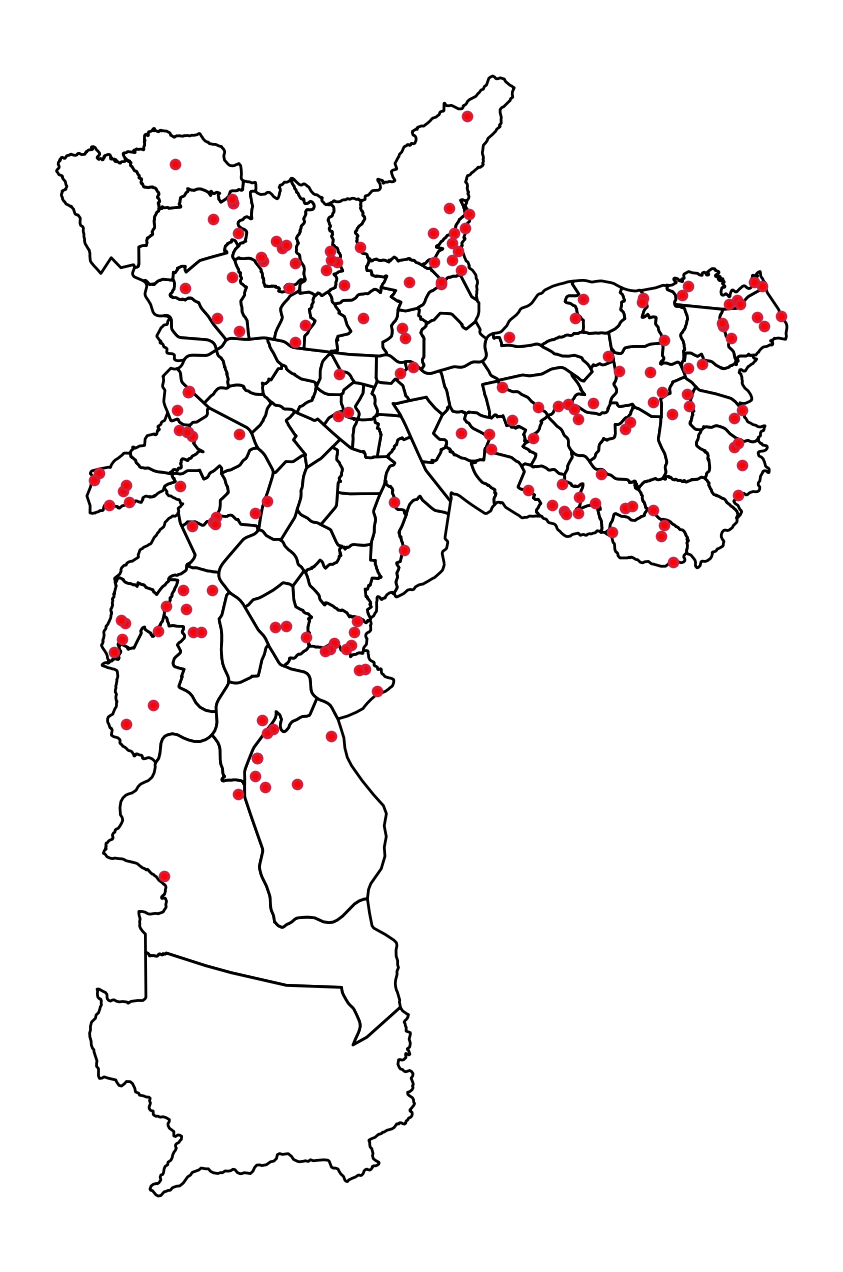

In [19]:
%config InlineBackend.figure_format='retina'

fig, ax = plt.subplots(figsize=(10,8))
ax.set_axis_off()
ax.set_aspect('equal')
mun_sp.plot(ax=ax, color='white', edgecolor='black')
lep_2007.plot(ax=ax, marker='o', color='red',edgecolor='#D21F3C', markersize=10)
plt.show();

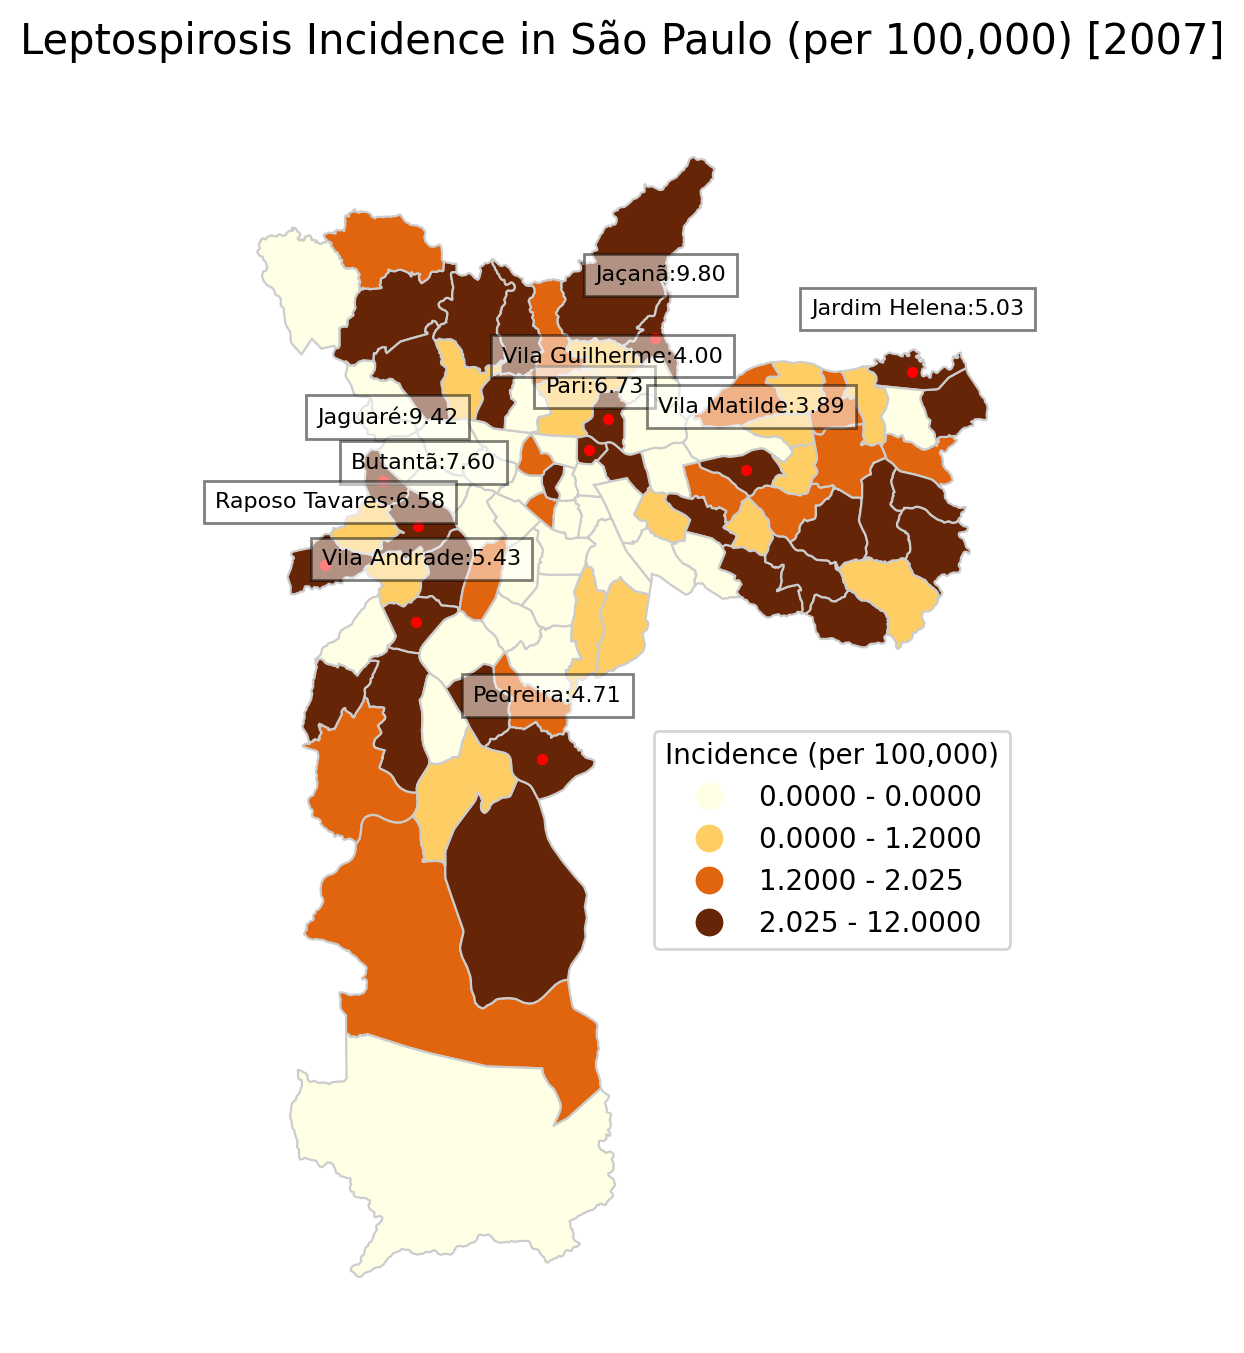

In [20]:
%config InlineBackend.figure_format='retina'

labels = ['0.0000 - 0.0000', '0.0000 - 1.2000', '1.2000 - 2.025', '2.025 - 12.0000'] 
bins = [float('-inf'),1e-10, 1.2, 2.025, 12]


# Data Process
cases_by_district = gpd.sjoin(lep_2007, mun_sp, how="inner", predicate="within")
incidence = cases_by_district.groupby("NOME").size().reset_index(name="case_count")

districts = mun_sp.merge(incidence, on="NOME", how="left").fillna(0)
districts['incidence_per_100000'] = (districts['case_count'] / districts['POP_2000']) * 100000
districts['incidence_per_100000'] = districts['incidence_per_100000'].fillna(0)
districts['incidence_category'] = pd.cut(districts['incidence_per_100000'], bins=bins, labels=labels, right=False)


fig, ax = plt.subplots(figsize=(10,8))
districts.plot(column='incidence_category', cmap='YlOrBr', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
for idx, row in districts.sort_values("incidence_per_100000",ascending=False).head(10).iterrows():

    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    
    offset_x = 0.001 * (x)  
    offset_y = 0.0005 * (y)  
    
    ax.plot(x, y, 'o', color='red', markersize=3)
    ax.text(x+offset_x, y+offset_y, 
            f"{row['NOME']}:{row.incidence_per_100000:.2f}", fontsize=8, ha='center', 
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))


legend = ax.get_legend()
legend.set_title("Incidence (per 100,000)")
legend.set_bbox_to_anchor((1, 0.5))

ax.set_title("Leptospirosis Incidence in São Paulo (per 100,000) [2007]", fontsize=15)
ax.set_axis_off()
ax.set_aspect('equal')

plt.show();

### Dados históricos

#### Distância de rios


Processing interval: 0 100


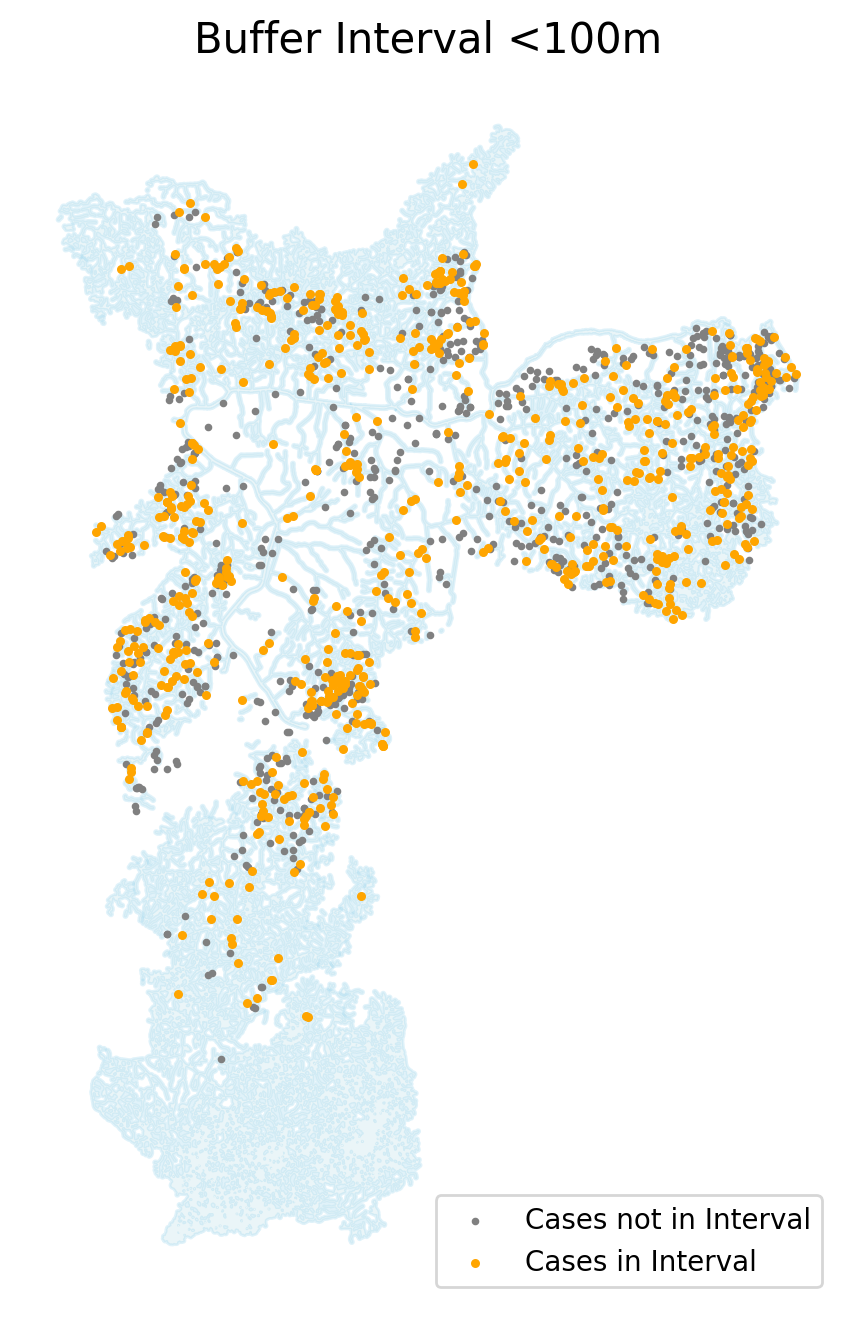

Processing interval: 100 200


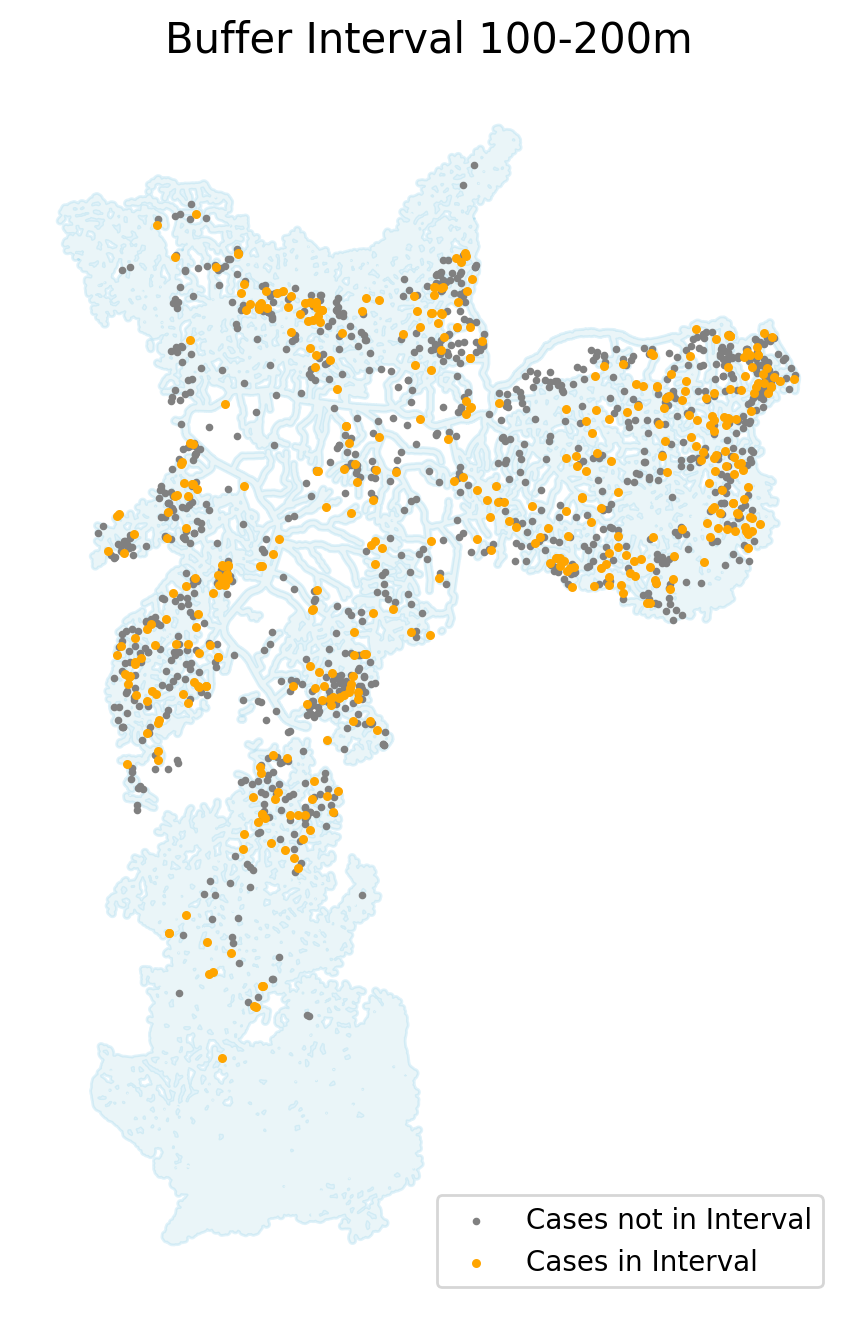

Processing interval: 200 300


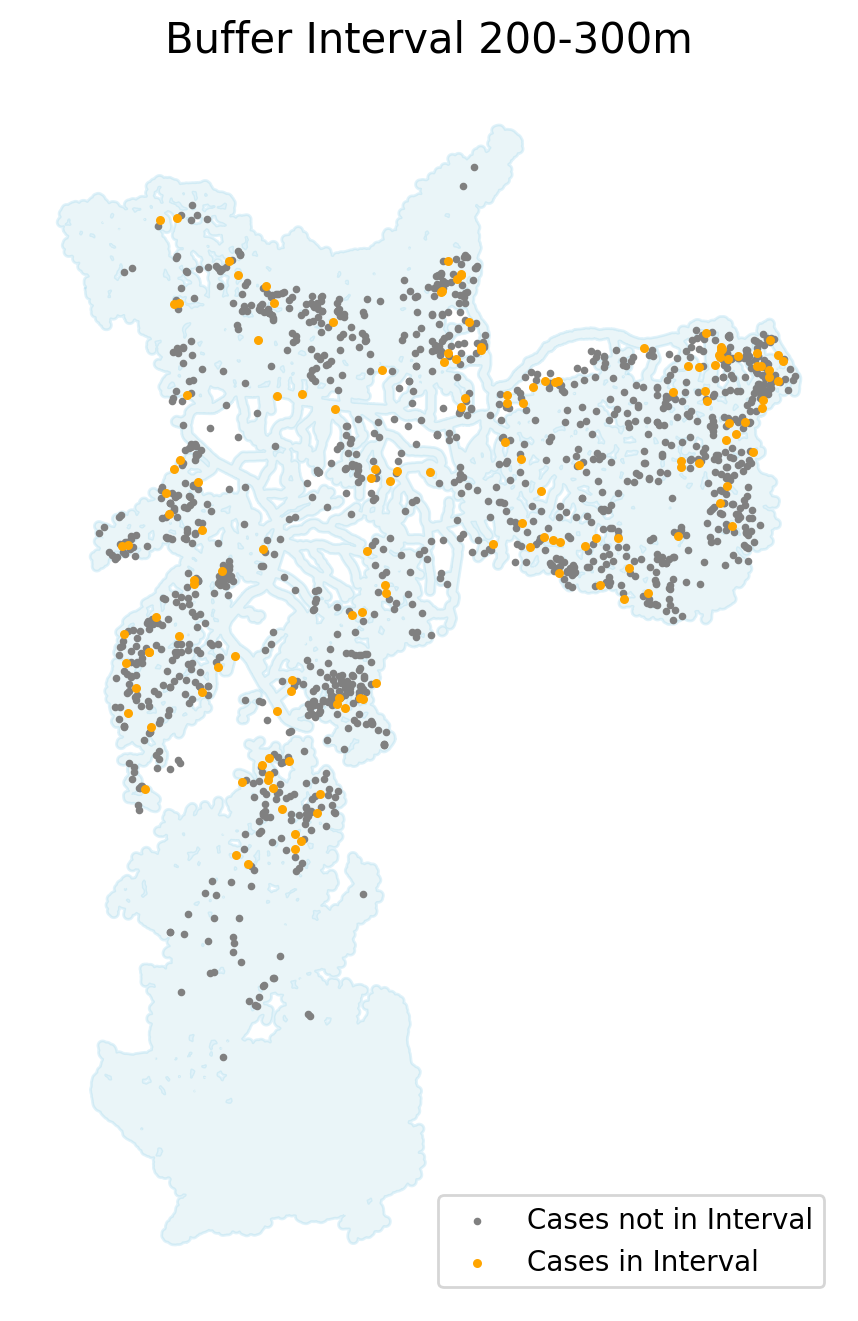

Processing interval: 300 400


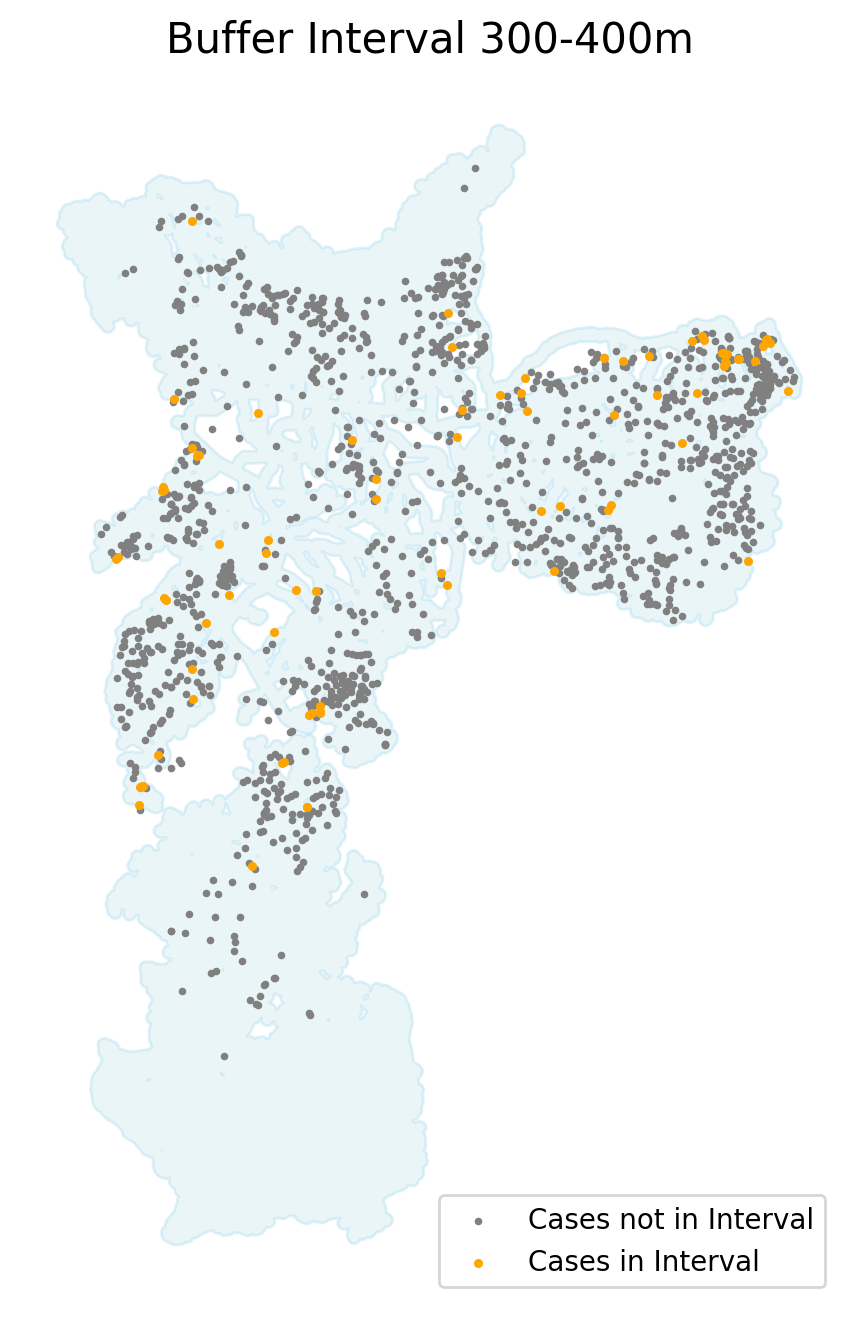

Processing interval: 400 500


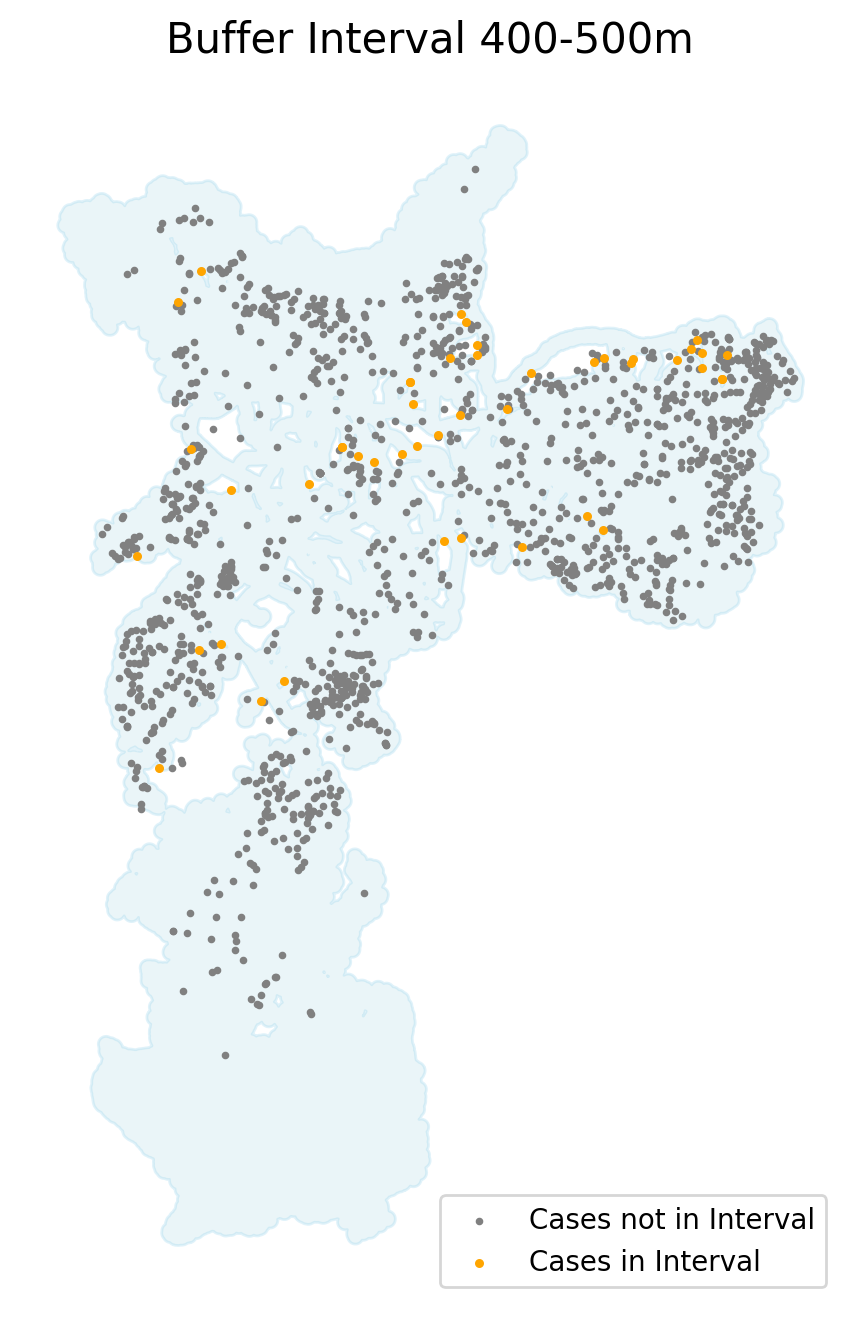

Processing interval: 500 inf
  distance_interval  case_count
0             <100m         723
1          100-200m         432
2          200-300m         151
3          300-400m          83
4          400-500m          46


In [21]:
%config InlineBackend.figure_format='retina'

buffer_intervals = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500), (500, float('inf'))]

def create_buffer_geo_df(distance, hid_sp):
    buffer = hid_sp.buffer(distance).union_all()
    return gpd.GeoDataFrame(geometry=[buffer], crs=hid_sp.crs)

def count_cases_in_interval(lower, upper, lep_sp, hid_sp):
    if upper != float('inf'):
        upper_gdf = create_buffer_geo_df(upper, hid_sp)

        if lower == 0:
            return gpd.sjoin(lep_sp, upper_gdf, predicate='within')
        else:
            lower_gdf = create_buffer_geo_df(lower, hid_sp)
            interval_zone = gpd.overlay(upper_gdf, lower_gdf, how='difference')
            return gpd.sjoin(lep_sp, interval_zone, predicate='within')
    else:
        outer_gdf = create_buffer_geo_df(0.005, hid_sp)
        return lep_sp[~lep_sp.geometry.within(outer_gdf.geometry[0])]

interval_results_list = []

for lower, upper in buffer_intervals:
    print("Processing interval:", lower, upper)  
    cases_in_interval = count_cases_in_interval(lower, upper, lep_sp, hid_sp)

    if upper == float('inf'):
        break
    elif upper == 100:
        interval_name = "<100m"
    else:
        interval_name = f"{lower}-{upper}m"

    interval_results_list.append({'distance_interval': interval_name, 'case_count': len(cases_in_interval)})

    buffer_zone_gdf = create_buffer_geo_df(upper, hid_sp) if upper != float('inf') else create_buffer_geo_df(0.005, hid_sp)

    fig, ax = plt.subplots(figsize=(10,8))

    buffer_zone_gdf.plot(ax=ax, color='lightblue', edgecolor='skyblue', alpha=0.25, label="Buffer Zone")
    lep_sp.plot(ax=ax, color='gray', markersize=3, label="Cases not in Interval")
    cases_in_interval.plot(ax=ax, color='orange', markersize=5, label="Cases in Interval")
    
    ax.set_title(f"Buffer Interval {interval_name}", fontsize=15)
    ax.set_axis_off()
    ax.set_aspect('equal')
    
    plt.legend(loc='lower right')
    plt.show()
    
interval_results = pd.DataFrame(interval_results_list)

print(interval_results)

#### Densidade de rio

In [22]:
if hid_sp.geom_type.iloc[0] != 'LineString':
    hid_sp = hid_sp.explode().reset_index(drop=True)
    hid_sp = hid_sp[hid_sp.geom_type == 'LineString']
    
hid_sp['river_length_km'] = hid_sp.length / 1000

rivden_data = hid_sp.groupby('NOME')['river_length_km'].sum().reset_index()
rivden_data = rivden_data.merge(mun_sp[['NOME', 'geometry']], on='NOME', how='inner')
rivden_data = gpd.GeoDataFrame(rivden_data, crs=CRS,geometry=rivden_data.geometry)
rivden_data['sector_area_km2'] = rivden_data.area / 1e6
rivden_data['RIVDEN'] = rivden_data['river_length_km'] / rivden_data['sector_area_km2']

# # Classify RIVDEN values into specified categories
# rivden_data['RIVDEN_class'] = pd.cut(rivden_data['RIVDEN'],
#                                      bins=[0, 20, 40, 60, 80, 100, float('inf')],
#                                      labels=['0-20 km/km²', '20-40 km/km²', '40-60 km/km²', '60-80 km/km²', '80-100 km/km²', '≥100 km/km²'])
rivden_data['RIVDEN_class'] = pd.qcut(rivden_data['RIVDEN'], q=4, labels=['Low', 'Moderate', 'High', 'Very High'],retbins=True)[0]
print(rivden_data[['NOME', 'RIVDEN', 'RIVDEN_class']])

                 NOME    RIVDEN RIVDEN_class
0   Alto de Pinheiros  0.618513          Low
1          Anhangüera  3.480352    Very High
2          Aricanduva  1.715443     Moderate
3         Artur Alvim  1.897432     Moderate
4         Barra Funda  2.853601    Very High
..                ...       ...          ...
91       Vila Matilde  2.328946         High
92      Vila Medeiros  1.477616     Moderate
93      Vila Prudente  1.471112     Moderate
94         Vila Sônia  2.591133         High
95          Água Rasa  2.278915         High

[96 rows x 3 columns]


In [23]:
lep_counts = gpd.sjoin(lep_sp, rivden_data, predicate='within')
lep_slope_counts = lep_counts.groupby('RIVDEN_class').size().reset_index(name='case_count')
lep_slope_counts;

#### Declividade do terreno

In [24]:
dem_path = f'{PROCESSED}/gdem/reprojected_dem.tif'
with rasterio.open(dem_path) as src:
    dem = src.read(1)  # Read the elevation data as a 2D array
    dem_transform = src.transform 

dy, dx = np.gradient(dem, src.res[0], src.res[1])
slope_rad = np.arctan(np.sqrt(dx**2 + dy**2))
slope_deg = np.degrees(slope_rad)

slope_classes = np.digitize(slope_deg, bins=[5, 10, 15, 20, 25,np.inf]) 
slope_classes = slope_classes.astype(np.int32) 

slope_polygons = []
for shape, value in shapes(slope_classes, transform=dem_transform):
    if value > 0:
        slope_polygons.append({'geometry': shape, 'slope_class': value})

In [25]:
from shapely.geometry import shape
# Create a GeoDataFrame for slope classes
for feature in slope_polygons:
    feature['geometry'] = shape(feature['geometry'])

slope_gdf = gpd.GeoDataFrame(slope_polygons, crs=CRS)
slope_gdf.sindex

slope_gdf = gpd.overlay(slope_gdf, mun_sp, how="intersection")

# Define slope class labels
slope_gdf['slope_class_label'] = slope_gdf['slope_class'].map({
    1: '0-5°', 2: '5-10°', 3: '10-15°', 4: '15-20°', 5: '20-25°', 6: '>25°'
})

# Count leptospirosis cases in each slope class polygon
lep_counts = gpd.sjoin(lep_sp, slope_gdf, predicate='within')
lep_slope_counts = lep_counts.groupby('slope_class_label').size().reset_index(name='case_count')

# Display results
print(lep_slope_counts.sort_values('case_count',ascending=False))

  slope_class_label  case_count
0              0-5°         565
4             5-10°         344
1            10-15°          91
2            15-20°          21
3            20-25°           5


#### Incidência de Leptospirose

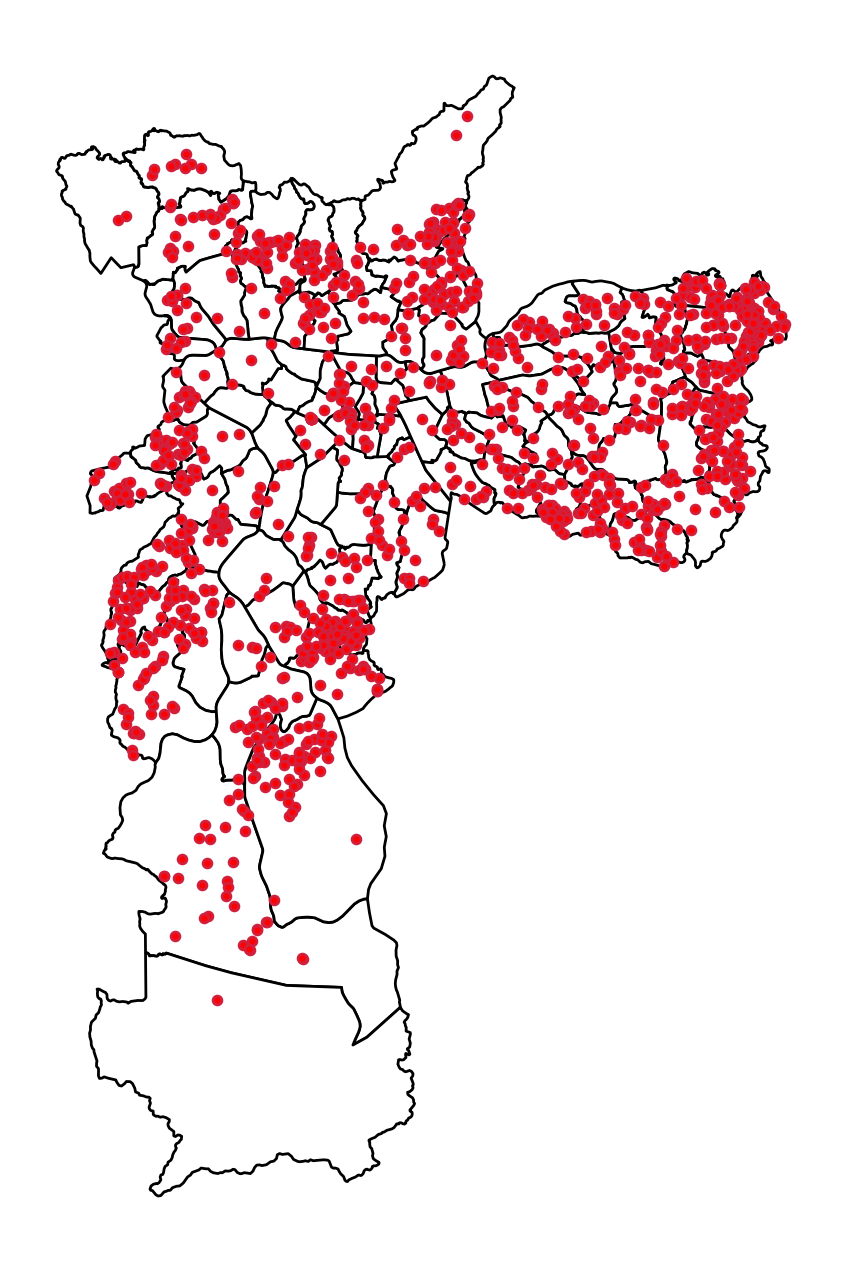

In [26]:
%config InlineBackend.figure_format='retina'

fig, ax = plt.subplots(figsize=(10,8))
ax.set_axis_off()
ax.set_aspect('equal')
mun_sp.plot(ax=ax, color='white', edgecolor='black')
lep_sp.plot(ax=ax, marker='o', color='red',edgecolor='#D21F3C', markersize=10)
plt.show();

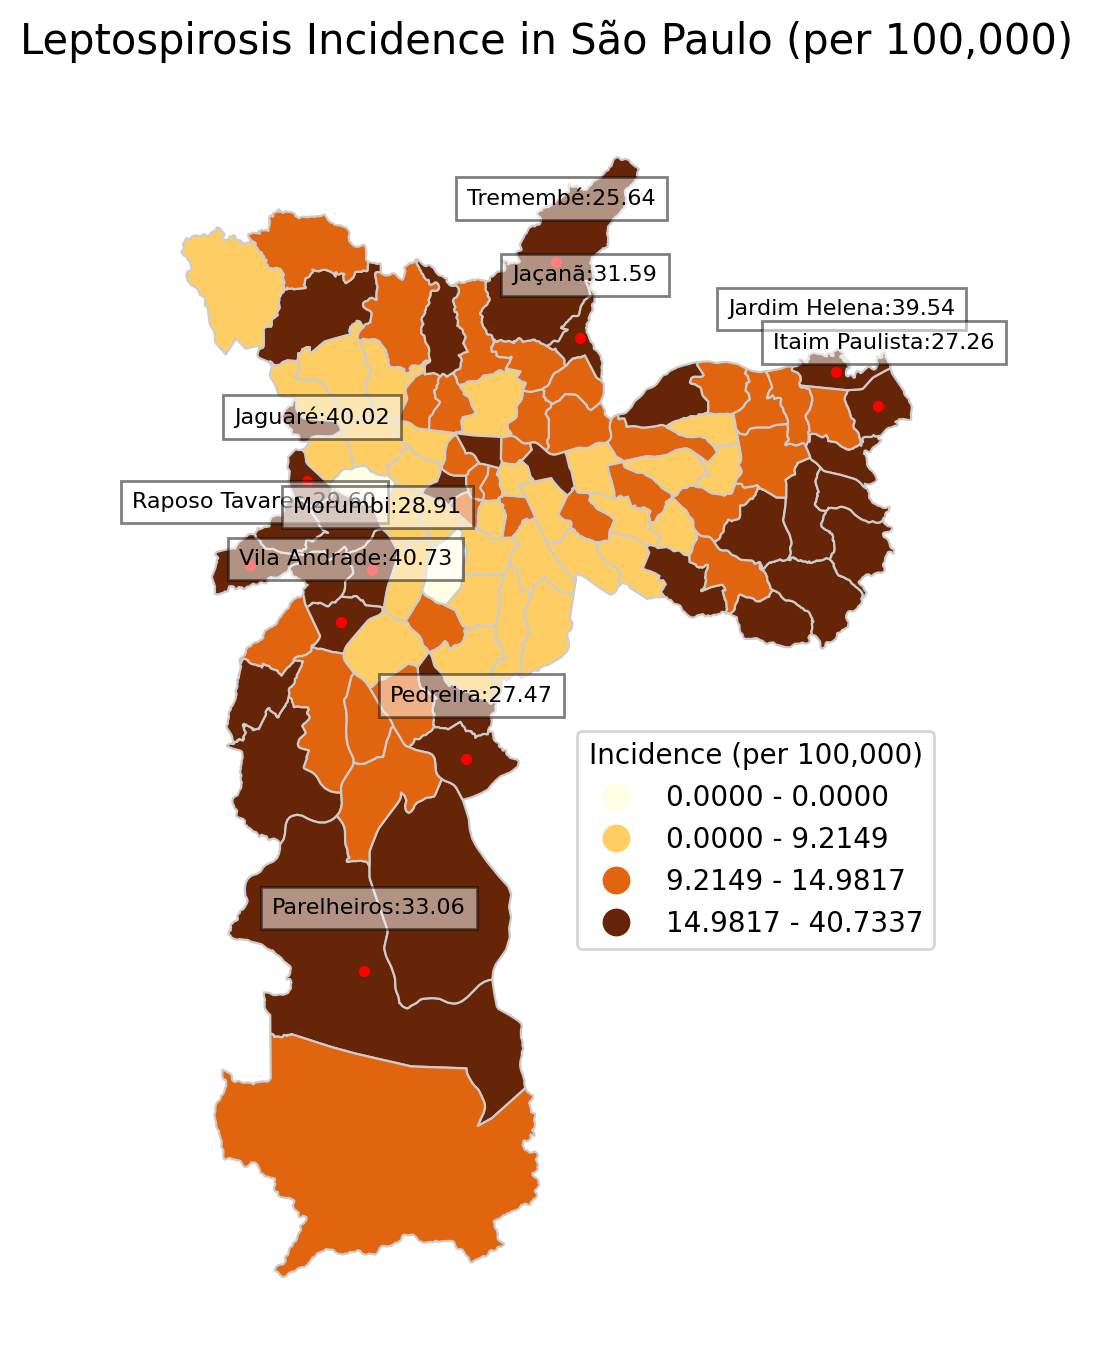

In [27]:
%config InlineBackend.figure_format='retina'

labels = ['0.0000 - 0.0000', '0.0000 - 9.2149', '9.2149 - 14.9817', '14.9817 - 40.7337'] 
bins = [float('-inf'),1e-10, 1.2, 2.025, 12]
bins = [ float('-inf'), 1e-10, 9.21494803, 14.98165791, 40.73375063]
pd.cut(districts['incidence_per_100000'], bins=bins, labels=labels, right=False)

# Data Process
cases_by_district = gpd.sjoin(lep_sp, mun_sp, how="inner", predicate="within")
incidence = cases_by_district.groupby("NOME").size().reset_index(name="case_count")

districts = mun_sp.merge(incidence, on="NOME", how="left").fillna(0)
districts['incidence_per_100000'] = (districts['case_count'] / districts['POP_2000']) * 100000
districts['incidence_per_100000'] = districts['incidence_per_100000'].fillna(0)
districts['incidence_category'] = pd.cut(districts['incidence_per_100000'], bins=bins, labels=labels, right=False)


fig, ax = plt.subplots(figsize=(10,8))
districts.plot(column='incidence_category', cmap='YlOrBr', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
for idx, row in districts.sort_values("incidence_per_100000",ascending=False).head(10).iterrows():

    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    
    offset_x = 0.001 * (x)  
    offset_y = 0.0005 * (y)  
    
    ax.plot(x, y, 'o', color='red', markersize=3)
    ax.text(x+offset_x, y+offset_y, 
            f"{row['NOME']}:{row.incidence_per_100000:.2f}", fontsize=8, ha='center', 
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))


legend = ax.get_legend()
legend.set_title("Incidence (per 100,000)")
legend.set_bbox_to_anchor((1, 0.5))

ax.set_title("Leptospirosis Incidence in São Paulo (per 100,000)", fontsize=15)
ax.set_axis_off()
ax.set_aspect('equal')

plt.show();

## Análise de Pontos

In [28]:
from matplotlib.patches import Ellipse
import seaborn as sns
import pointpats.quadrat_statistics as qs

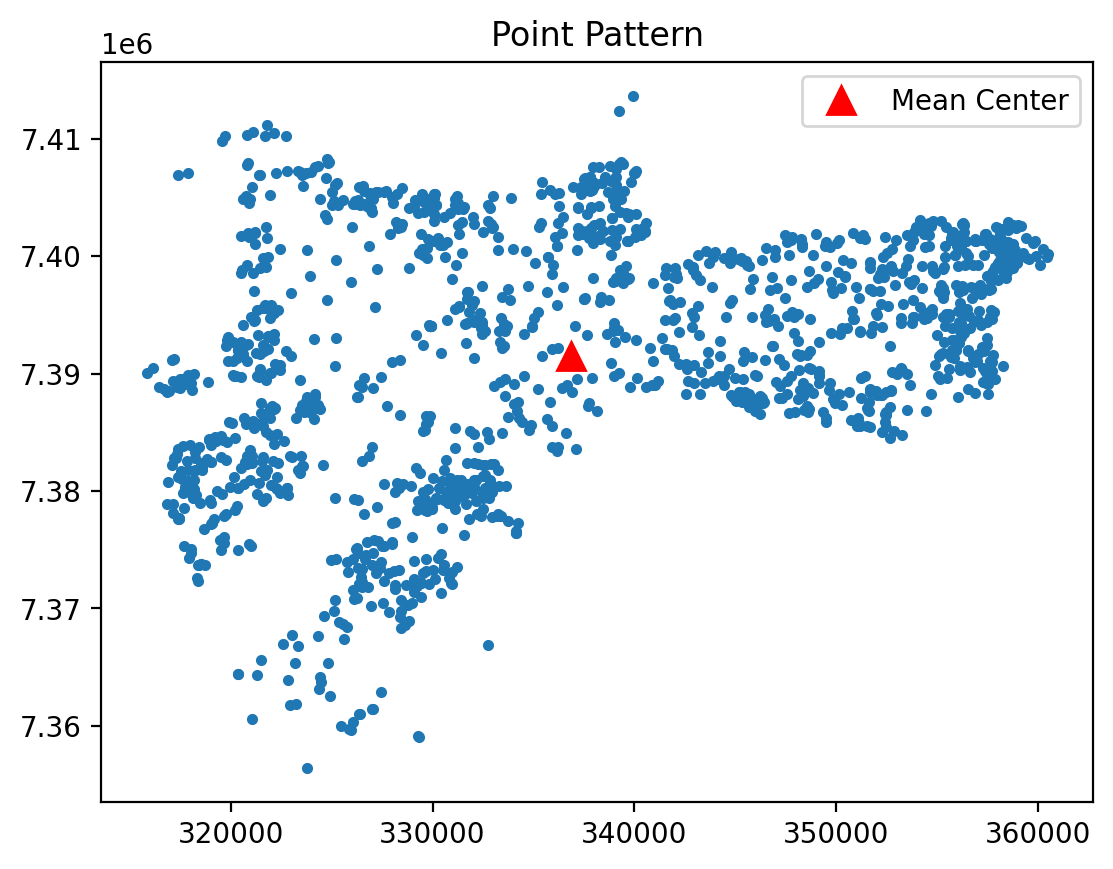

In [29]:
x = lep_sp.geometry.x
y = lep_sp.geometry.y

points = np.vstack((x, y)).T

pp = PointPattern(points)

mc = mean_center(pp.points)
pp.plot()
plt.plot(mc[0], mc[1], 'r^', markersize=10, label='Mean Center')
plt.legend()
plt.show();

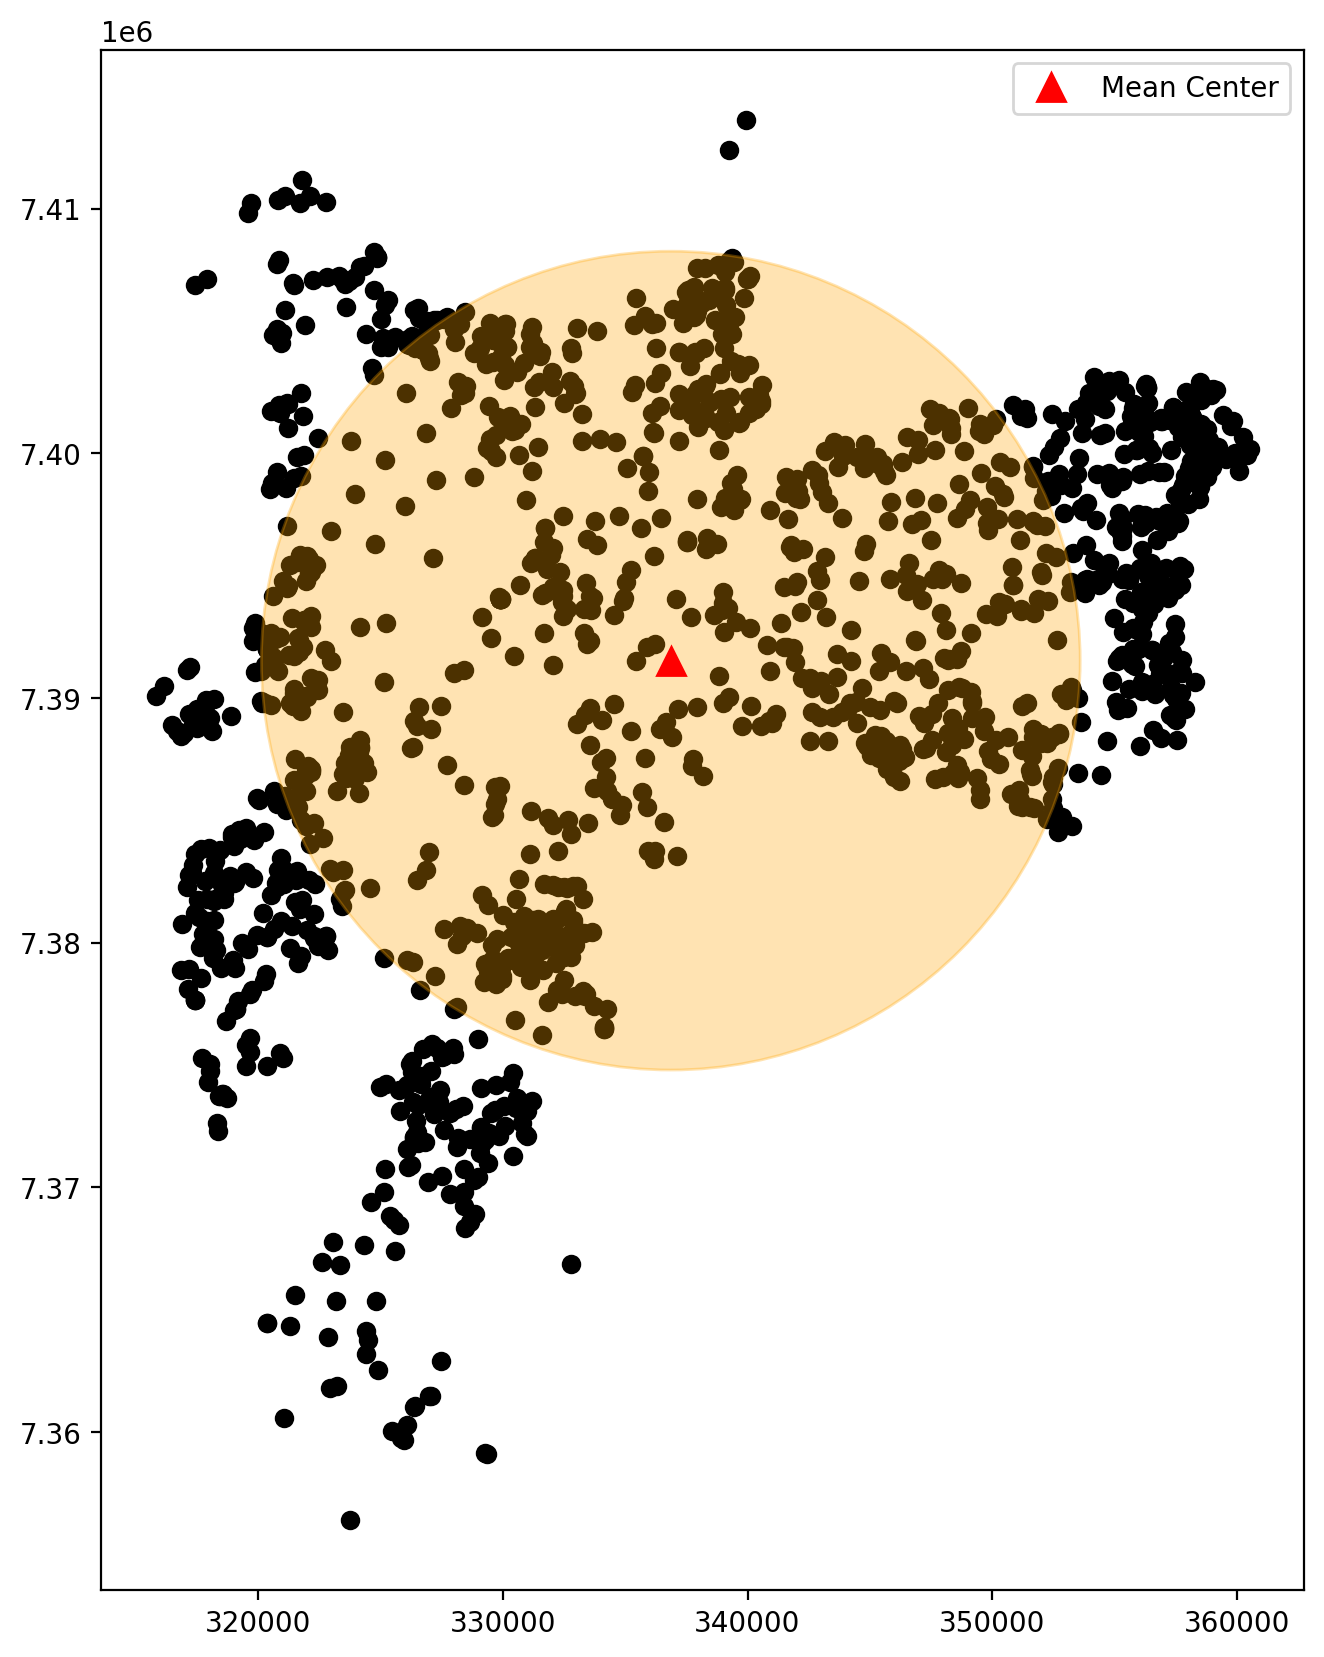

In [30]:
stdd = std_distance(pp.points)

fig, ax = plt.subplots(figsize=(8,10))

lep_sp.plot(ax=ax, color='black')

plt.plot(mc[0], mc[1], 'r^', label='Mean Center', markersize=10)

circle1=plt.Circle((mc[0], mc[1]), stdd, color='orange', alpha = 0.3)
ax.add_artist(circle1)

plt.legend()
plt.plot()
plt.show()

[]

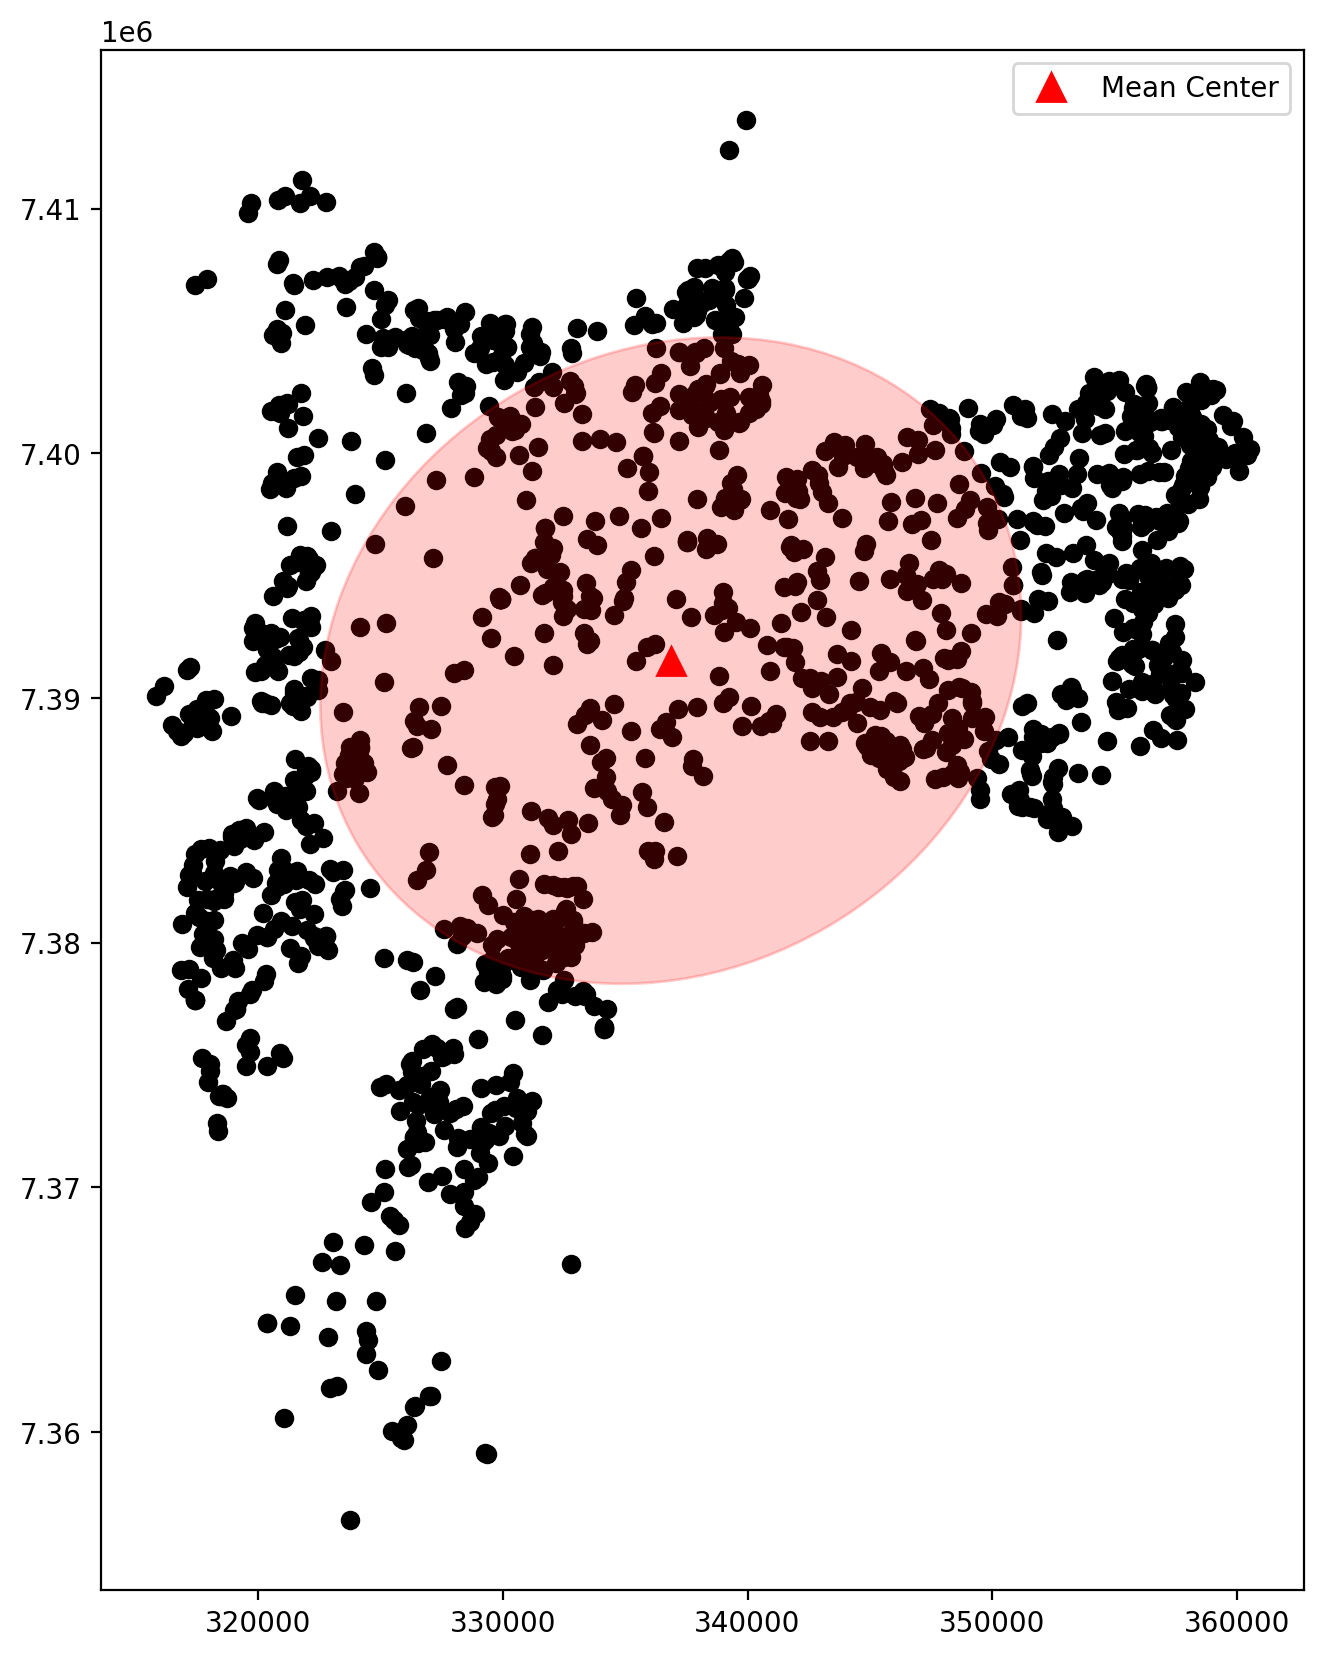

In [ ]:
# Definição da elipe
sx, sy, theta = ellipse(pp.points)

# Cálculo do theta
theta_degree = np.degrees(theta)

# Construção da elipse
elipse = Ellipse(
    xy=mean_center(pp.points),
    width=sx*2,
    height=sy*2,
    angle = -theta_degree,
    color='red',
    alpha = 0.2
)

fig, ax = plt.subplots(figsize=(8,10))

# Plotagem dos pontos
lep_sp.plot(ax=ax, color='black')

# Plotagem do centro médio
plt.plot(mc[0], mc[1], 'r^', label='Mean Center', markersize=10)

# Plotagem da elipse
ax.add_artist(elipse)

plt.legend()
plt.plot();

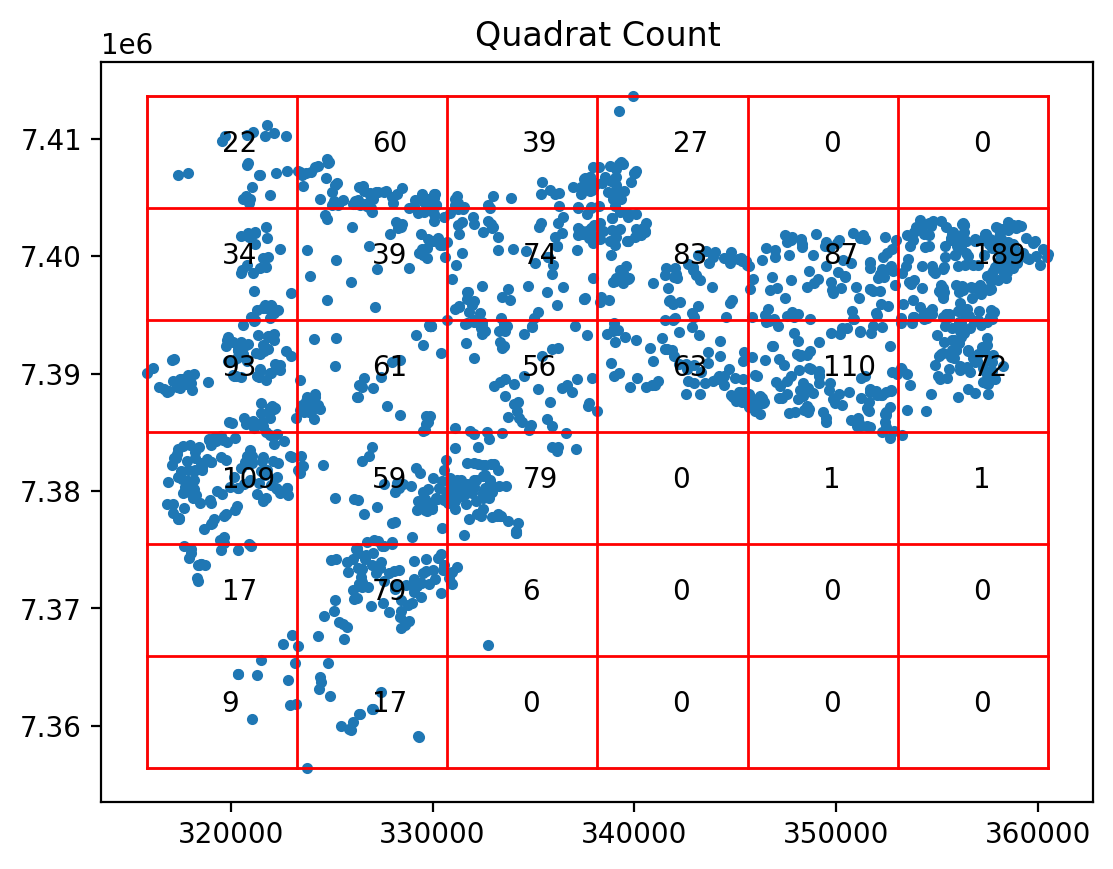

In [32]:
q_r = qs.QStatistic(pp, shape='rectangle', nx=6, ny=6)
q_r.plot();

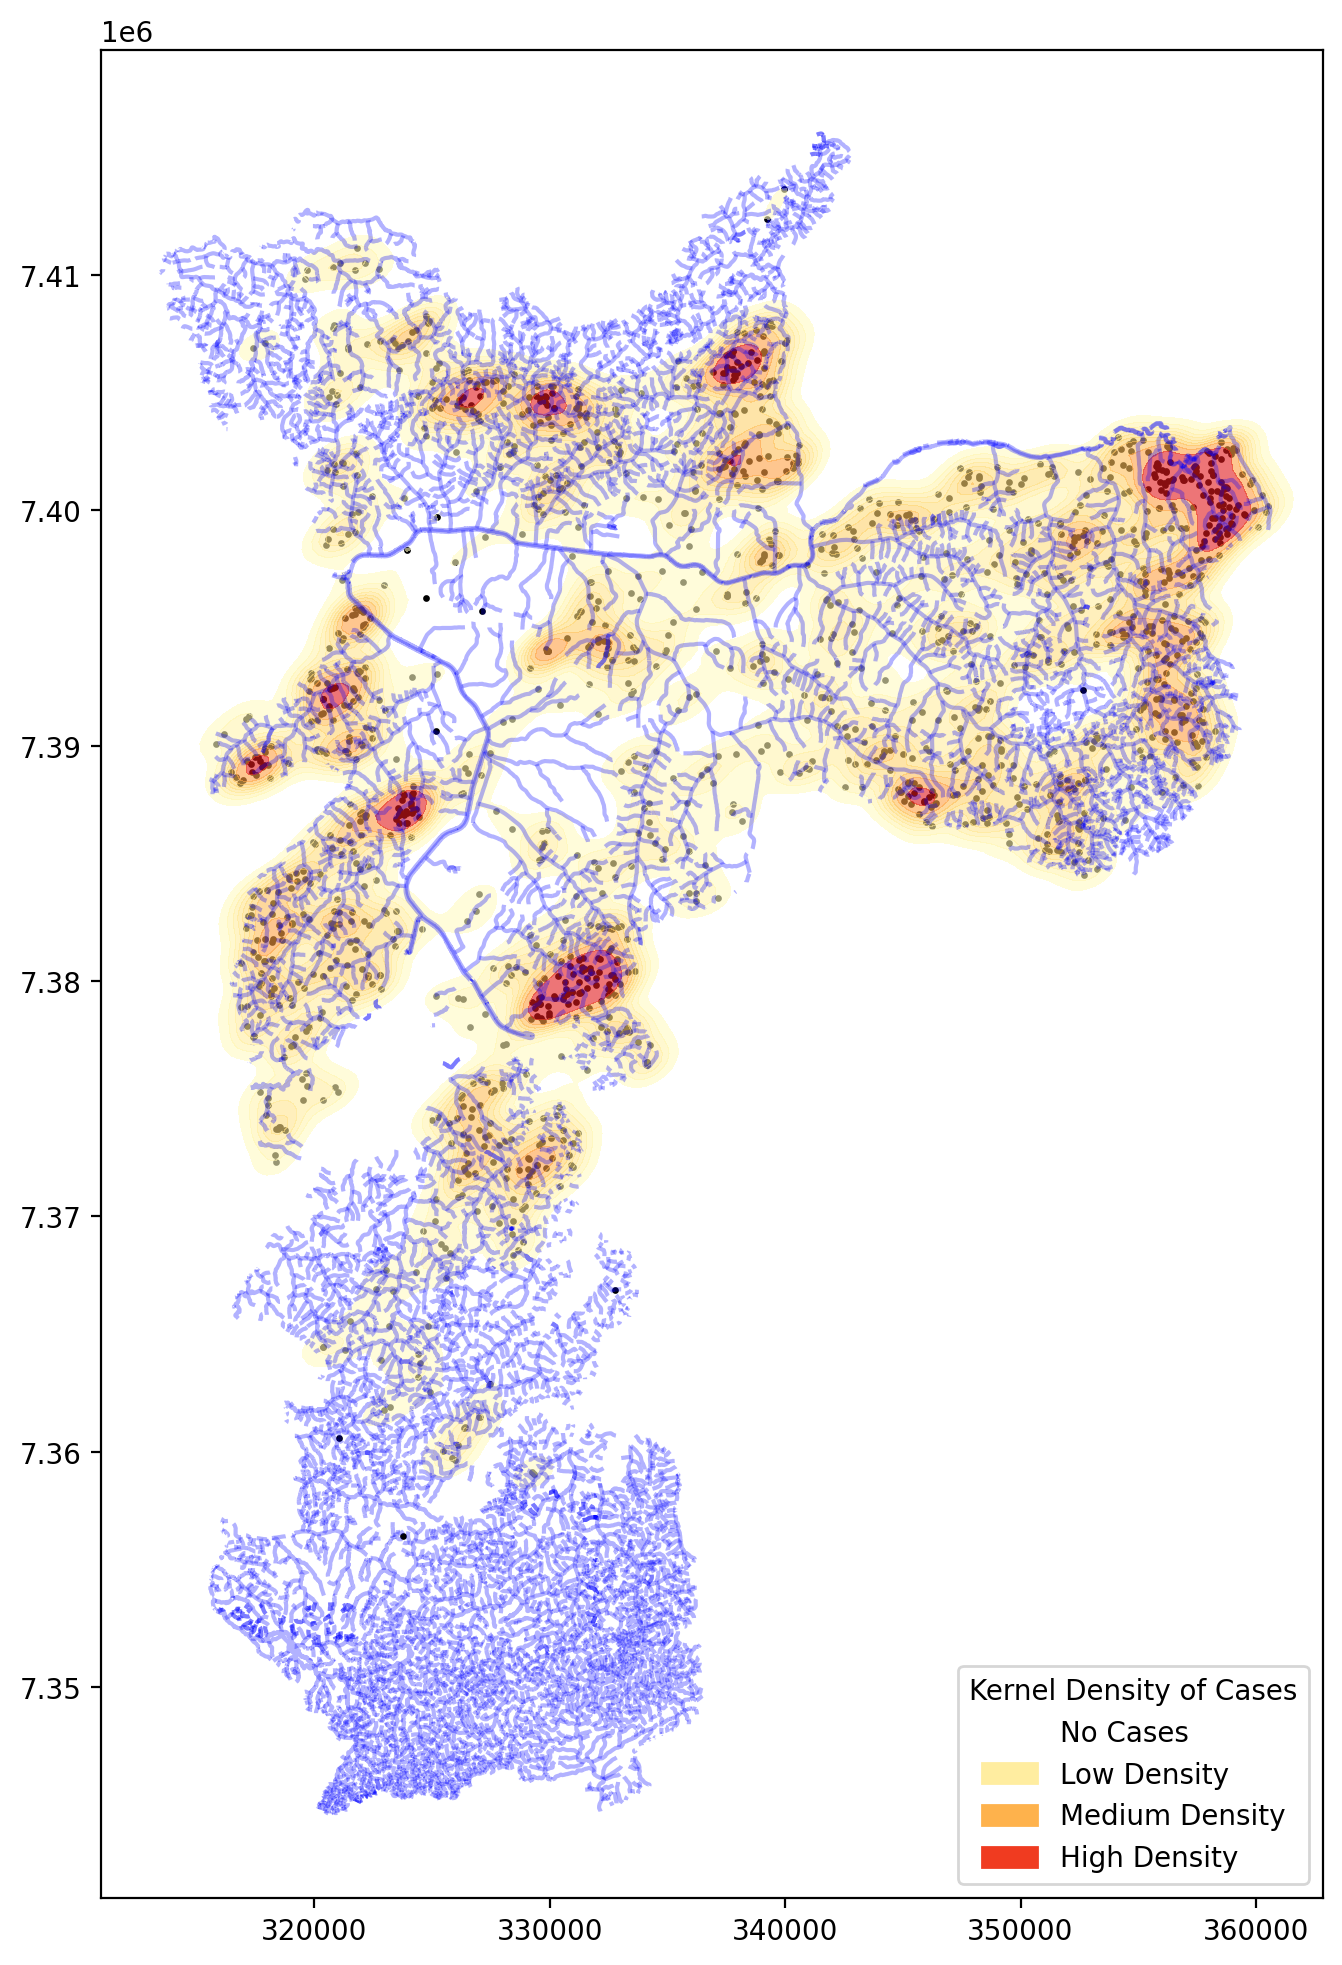

In [33]:
%config InlineBackend.figure_format='retina'

# Cria figura
fig, ax = plt.subplots(figsize=(8, 12))

# mun_sp.plot(ax=ax, color='white', edgecolor='black')

hid_sp.plot(
    ax=ax,
    # color='blue',
    edgecolor='blue',
    alpha=0.3,
)

# Plota pontos
lep_sp.plot(
    ax=ax,
    color='black',
    markersize=2
)


# Plota mapa de kernel
sns.kdeplot(
    x = points[:,0],
    y= points[:,1],
    fill=True,
    cmap='YlOrRd',
    ax=ax,
    alpha=0.6,
    bw_adjust=0.2,
    # levels=[0.1, 0.3, 0.6, 0.9],
)

import matplotlib.patches as mpatches
legend_patches = [
    mpatches.Patch(color='white', label='No Cases'),
    mpatches.Patch(color='#FFEDA0', label='Low Density'),
    mpatches.Patch(color='#FEB24C', label='Medium Density'),
    mpatches.Patch(color='#F03B20', label='High Density')
]
plt.legend(handles=legend_patches, title="Kernel Density of Cases", loc='lower right')

# plt.legend()
plt.plot();

## Considerações Finais

Nos dois contextos temporais analisados, 2007 e histórico, os resultados em relação à análise da distribuição espacial dos casos de leptospirose em São Paulo revelaram uma correlação significativa com a densidade fluvial e a proximidade dos rios, em conformidade com o estudo de referência. 

A análise da distância dos rios mostrou que a maioria dos casos de leptospirose ocorre em domicílios situados a menos de 200 metros dos rios, indicando uma relação direta entre a presença de rios e a incidência da doença. Além disso, a densidade fluvial também se mostrou um fator relevante, com uma concentração maior de casos em áreas com maior presença de rios.

Alguns pontos de divergência foram observados em relação ao estudo original, como a análise de incidência de casos por bairro. Isso pode ser atribuído a diferenças na metodologia de coleta e processamento dos dados.

